In [1]:
import numpy as np
import random
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pickle

In [17]:

def generate_random_shape(num_cells=10):
    size=9
    # Initialize a 9x9 grid filled with 0s
    grid = np.zeros((size, size), dtype=int)

    # Start from a random position.
    start_row, start_col = random.randint(0, size-1), random.randint(0, size-1)
    shape_cells = []
    if(num_cells>0):
        
        grid[start_row, start_col] = 1
        shape_cells.append((start_row, start_col))
    
    # Track cells that form the shape
    
    # Define possible directions (up, down, left, right)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while len(shape_cells) < num_cells:
        # Pick a random cell from the current shape
        cell = random.choice(shape_cells)
        
        # Try adding a neighboring cell to the shape
        random.shuffle(directions)
        for dr, dc in directions:
            new_row, new_col = cell[0] + dr, cell[1] + dc
            # Check if the new cell is within bounds and empty
            if 0 <= new_row < size and 0 <= new_col < size and grid[new_row, new_col] == 0:
                grid[new_row, new_col] = 1
                shape_cells.append((new_row, new_col))
                break  # Add one cell at a time and continue

    return grid

# Generate and display a random shape
def display_shape(grid,ax=None):
    if(ax == None):
        plt.figure(figsize=(6, 6))
        plt.imshow(grid, cmap='Reds', interpolation='nearest')

        # Customize the grid for a clear appearance
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        plt.grid(visible=False)
        plt.show()
    else:
        ax.imshow(grid, cmap='Reds', interpolation='nearest')
def display_shape_holder(shape_holder):
    plt.figure(figsize=(6, 6))
    # Custom colormap to distinguish 0 (white), 1 (blue), and 2 (gray)
    cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])
    plt.imshow(shape_holder, cmap=cmap, interpolation='nearest')

    # Customize the grid for a clear appearance
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.grid(visible=False)
    plt.show()
def center_shape(grid):
    # Find the bounding box of the shape in the grid
    rows, cols = np.where(grid == 1)
    if len(rows) == 0 or len(cols) == 0:
        return grid  # Return as is if there's no shape in the grid

    # Bounding box coordinates
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()

    # Height and width of the bounding box
    shape_height = max_row - min_row + 1
    shape_width = max_col - min_col + 1

    # Calculate the starting position to center the bounding box
    start_row = (grid.shape[0] - shape_height) // 2
    start_col = (grid.shape[1] - shape_width) // 2

    # Create a new empty grid
    centered_grid = np.zeros_like(grid)

    # Copy the shape into the new centered grid
    centered_grid[start_row:start_row + shape_height, start_col:start_col + shape_width] = \
        grid[min_row:max_row + 1, min_col:max_col + 1]

    return centered_grid

In [3]:
def generate_shape_holder( num_touch_zones=10, num_non_touch_zones=10):
    size=9
    # Initialize a 9x9 grid filled with 0s
    shape_holder = np.zeros((size, size), dtype=int)
    
    # Place `1`s (zones where the shape must touch)
    touch_positions = random.sample([(i, j) for i in range(size) for j in range(size)], num_touch_zones)
    for (row, col) in touch_positions:
        shape_holder[row, col] = 1
    
    # Place `2`s (zones where the shape must not touch)
    non_touch_positions = random.sample(
        [(i, j) for i in range(size) for j in range(size) if shape_holder[i, j] == 0],
        num_non_touch_zones
    )
    for (row, col) in non_touch_positions:
        shape_holder[row, col] = 2
    
    return shape_holder

def can_fit_shape(shape, shape_holder):
    shape_size = shape.shape[0]
    holder_size = shape_holder.shape[0]
    
    # Slide the shape over the shape_holder grid
    for row_offset in range(holder_size - shape_size + 1):
        for col_offset in range(holder_size - shape_size + 1):
            # Check if the shape fits in this position
            if is_valid_position(shape, shape_holder, row_offset, col_offset):
                return True  # Found a valid position
    
    return False  # No valid position found

def is_valid_position(shape, shape_holder, row_offset, col_offset):
    shape_size = shape.shape[0]
    
    for i in range(shape_size):
        for j in range(shape_size):
            # Only check positions where shape has a '1'
            if shape[i, j] == 1:
                holder_value = shape_holder[row_offset + i, col_offset + j]
                
                # Check touch and non-touch constraints
                if holder_value == 2:
                    return False  # Shape overlaps a forbidden zone
                if holder_value == 1 and not touches_all_ones(shape, shape_holder, row_offset, col_offset):
                    return False  # Shape doesn't meet all touch requirements

    return True  # This position is valid

def touches_all_ones(shape, shape_holder, row_offset, col_offset):
    shape_size = shape.shape[0]
    # Convert positions of '1's in shape_holder to tuples
    required_ones = set(map(tuple, np.argwhere(shape_holder == 1)))
    touched_ones = set()
    
    for i in range(shape_size):
        for j in range(shape_size):
            # If shape has a '1' at this position, check if it touches a required '1'
            if shape[i, j] == 1:
                pos = (row_offset + i, col_offset + j)
                if pos in required_ones:
                    touched_ones.add(pos)

    # Ensure all '1's in shape_holder are touched by the shape
    return required_ones.issubset(touched_ones)


In [4]:
def checkFit(shape,shape_holder):
    
    for i in range(0,9):
        for j in range(0,9):
            if(shape_holder[i][j]==1 and shape[i][j]!=1):
                return False
            if(shape_holder[i][j]==2 and shape[i][j]==1):
                return False
    return True

In [5]:
def align_shape_to_top_left(grid):
    # Find the rows and columns that contain '1'
    rows, cols = np.where(grid == 1)
    
    # If there are no '1's, return the original grid
    if len(rows) == 0 or len(cols) == 0:
        return grid

    # Determine the bounding box of the shape
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()
    
    # Extract the non-empty part of the shape
    aligned_shape = grid[min_row:max_row + 1, min_col:max_col + 1]
    
    # Create a new grid (assuming the same size as original for simplicity)
    new_shape = np.zeros_like(grid)
    
    # Place the aligned shape in the top-left corner of the new grid
    new_shape[:aligned_shape.shape[0], :aligned_shape.shape[1]] = aligned_shape
    
    return new_shape

In [6]:
def align_shape_to_position(grid, x, y):
    # Find the rows and columns that contain '1'
    rows, cols = np.where(grid == 1)
    
    # If there are no '1's, return an empty grid
    if len(rows) == 0 or len(cols) == 0:
        return np.zeros_like(grid)

    # Determine the bounding box of the shape
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()
    
    # Extract the non-empty part of the shape
    aligned_shape = grid[min_row:max_row + 1, min_col:max_col + 1]
    
    # Create a new grid (assuming the same size as original for simplicity)
    new_shape = np.zeros_like(grid)
    
    # Calculate the dimensions of the aligned shape
    aligned_height, aligned_width = aligned_shape.shape
    
    # Check if the shape can fit at the given position (x, y)
    if x + aligned_height <= grid.shape[0] and y + aligned_width <= grid.shape[1]:
        # Place the aligned shape at the specified position
        new_shape[x:x + aligned_height, y:y + aligned_width] = aligned_shape
    
    return new_shape



In [7]:
def getAllPossiblity(grid):
    rotatedGrids = [grid]
    new_grid = grid
    for i in range(3):
        new_grid = rotate_grid_clockwise(new_grid)
        rotatedGrids.append(new_grid)
    allGrids = []
    for gr in rotatedGrids:
        new_grids = getAllPositions(gr)
        allGrids+=new_grids
    return allGrids

In [8]:
def checkAllAlignments(shape,shape_holder):
    pos = getAllPossiblity(shape)
    fit = False
    cpt = 0
    while(cpt<len(pos) and not fit ):
        fit = checkFit(pos[cpt],shape_holder)
        cpt+=1
    return fit

In [9]:
def getAlignment(shape,shape_holder):
    pos = getAllPossiblity(shape)
    fit = False
    cpt = 0
    while(cpt<len(pos) and not fit ):
        fit = checkFit(pos[cpt],shape_holder)
        if(fit):
            return pos[cpt]
        cpt+=1
    return fit

In [10]:
def getAllPositions(grid):
    endedx,endedy=False,False
    cptx,cpty=0,0
    newGrid=grid
    grids=[]
    while (not endedx):
        while(not endedy):
            newGrid=align_shape_to_position(newGrid,cptx,cpty)
            
            grids.append(newGrid)
            if(any(newGrid[:,-1])):
                endedy=True
            cpty+=1
        endedy=False
        cptx+=1
        cpty=0
        if(any(newGrid[-1,:])):
            endedx=True
    return grids

In [11]:
def rotate_grid_clockwise(grid):
    # Method 1: Using NumPy's built-in functions
    # rotated_grid = np.rot90(grid, k=-1)  # k=-1 for 90 degrees clockwise
    
    # Method 2: Manual rotation
    rows, cols = grid.shape
    rotated_grid = np.zeros((cols, rows), dtype=grid.dtype)  # New grid with swapped dimensions
    
    for i in range(rows):
        for j in range(cols):
            rotated_grid[j, rows - 1 - i] = grid[i, j]  # Place element in rotated position
    
    return rotated_grid
def display_shape_and_holder(shape, shape_holder):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the shape
    axs[0].imshow(shape, cmap='Reds', interpolation='nearest')
    axs[0].set_title("Shape")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].grid(visible=False)
    
    # Display the shape holder with a custom colormap
    cmap = colors.ListedColormap(['white', 'red', 'black'])
    axs[1].imshow(shape_holder, cmap=cmap, interpolation='nearest')
    axs[1].set_title("Shape Holder")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].grid(visible=False)
    
    blue_patch = mpatches.Patch(color='red', label='Touch')
    red_patch = mpatches.Patch(color='black', label="Don't Touch")
    fig.legend(handles=[blue_patch, red_patch], loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)

    plt.show()
def display_shape_and_holder2(shape, shape_holder, shape_holder2):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    
    # Display the shape
    axs[0].imshow(shape, cmap='Reds', interpolation='nearest')
    axs[0].set_title("Shape")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].grid(visible=False)
    
    # Display the shape holder with a custom colormap
    cmap = colors.ListedColormap(['white', 'red', 'black'])
    axs[1].imshow(shape_holder, cmap=cmap, interpolation='nearest')
    axs[1].set_title("Shape Holder")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].grid(visible=False)
    
    cmap = colors.ListedColormap(['white', 'red', 'black'])
    axs[2].imshow(shape_holder2, cmap=cmap, interpolation='nearest')
    axs[2].set_title("Shape Holder")
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].grid(visible=False)
    
    for ax in axs:
        ax.set_xticks(np.arange(-0.5, 9, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 9, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
        ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    
    blue_patch = mpatches.Patch(color='red', label='Touch')
    red_patch = mpatches.Patch(color='black', label="Don't Touch")
    fig.legend(handles=[blue_patch, red_patch], loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)

    plt.show()
def string_to_array(string):
    # Remove unwanted characters
    clean_string = string.replace('[', '').replace(']', '').replace('\n', ' ')
    
    # Convert string to a list of integers
    array_values = list(map(int, clean_string.split()))
    
    # Calculate the size of the array (assuming it's square)
    size = int(len(array_values) ** 0.5)
    
    # Reshape the flat list into a 2D array
    array = np.array(array_values).reshape(size, size)
    
    return array

In [12]:
def similarity(shape1,shape2):
    same = np.sum(shape1==shape2)
    ##tt = np.sum(shape1)
    tt=float(81)
    return same/tt

In [13]:
def compare_shapes(my_shapes):
    scores = dict()
    for c in range(len(my_shapes)):
        for d in range(len(my_shapes)):
            scoremax=0.0
            if(c!=d):
                posA = getAllPositions(my_shapes[c])
                posB = getAllPositions(my_shapes[d])
                for shape1 in posA:
                    for shape2 in posB:
                        scoremax=max(scoremax,similarity(shape1,shape2))
                if(str(my_shapes[c]) not in scores):
                    scores[str(my_shapes[c])]=dict()
                scores[str(my_shapes[c])][str(my_shapes[d])]=scoremax
    return scores

In [14]:
my_shapes = []

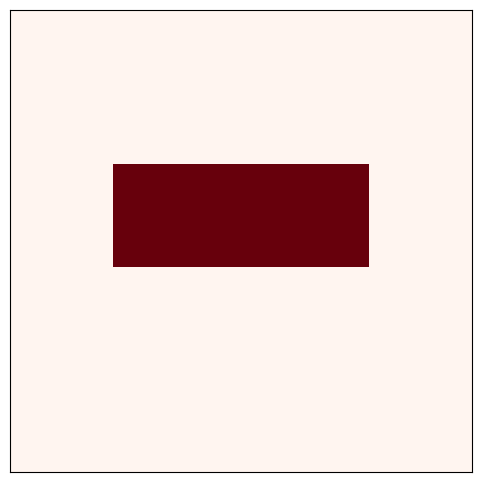

0


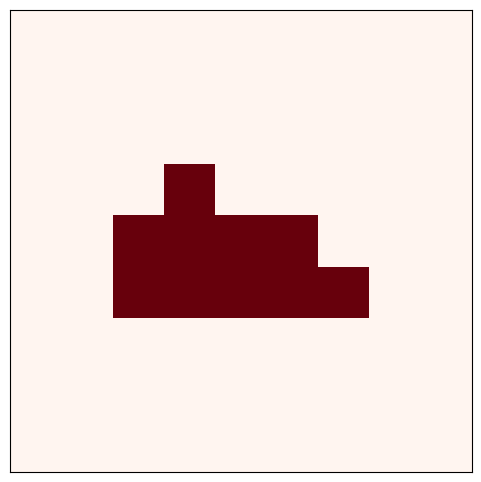

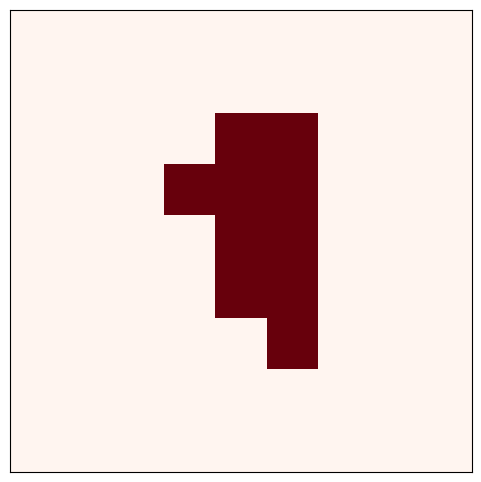

0


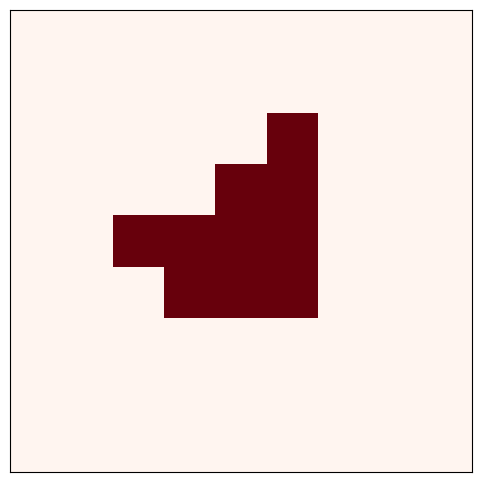

0


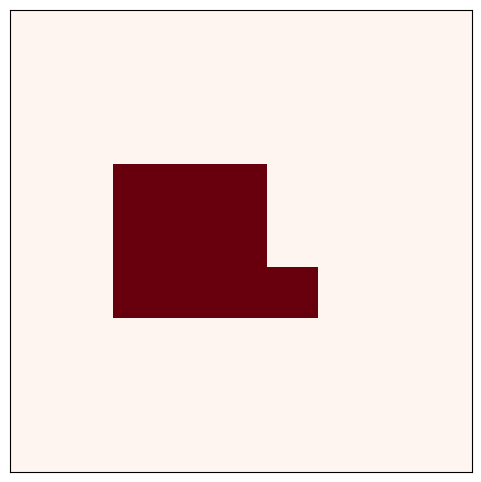

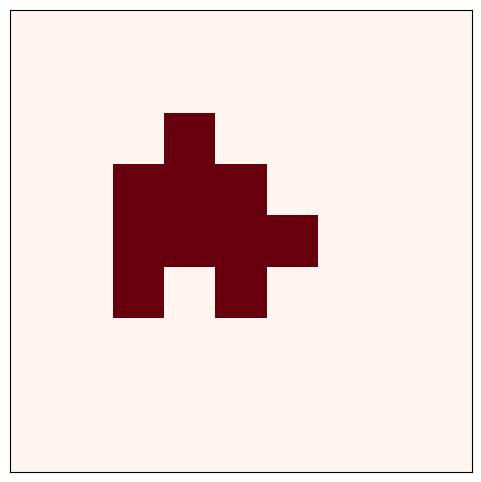

0


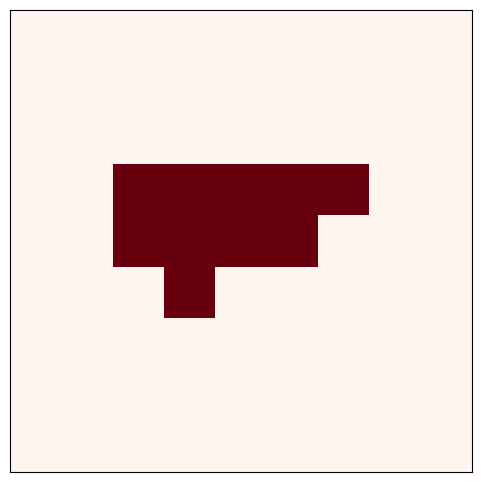

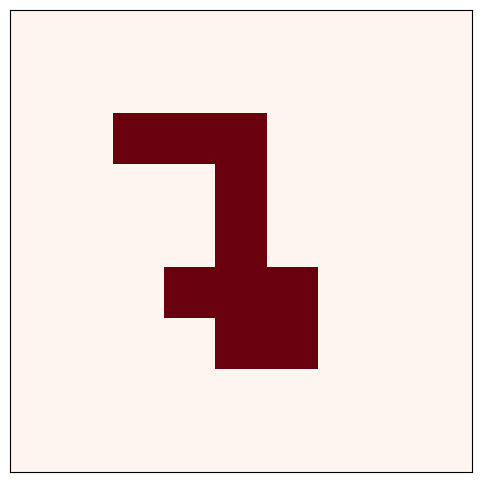

0


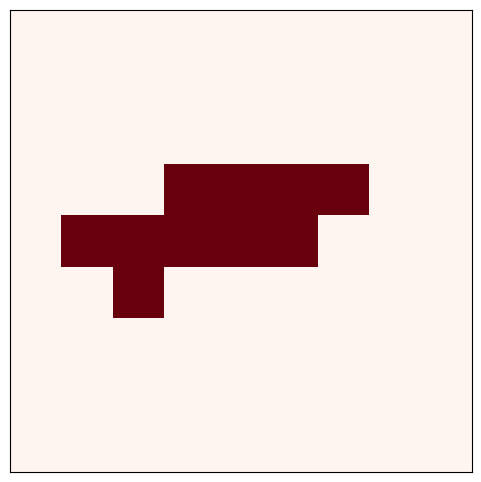

0


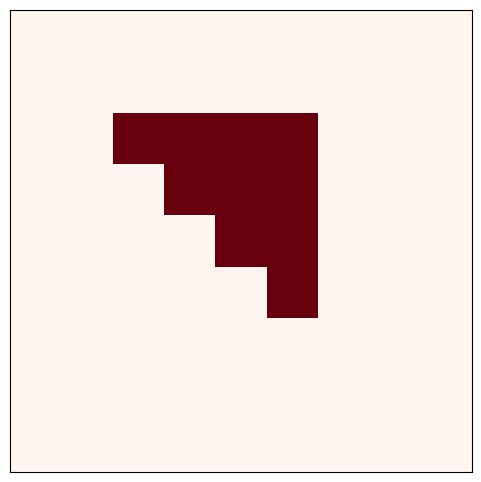

0


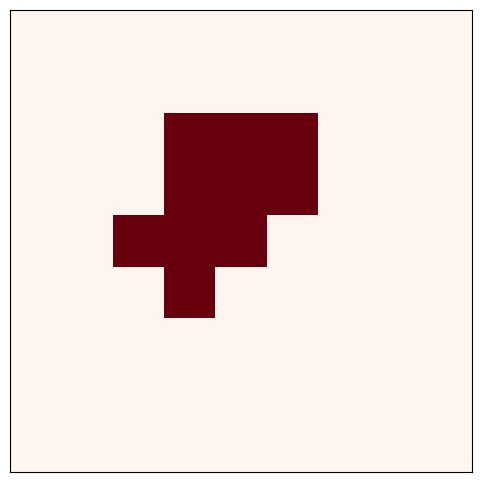

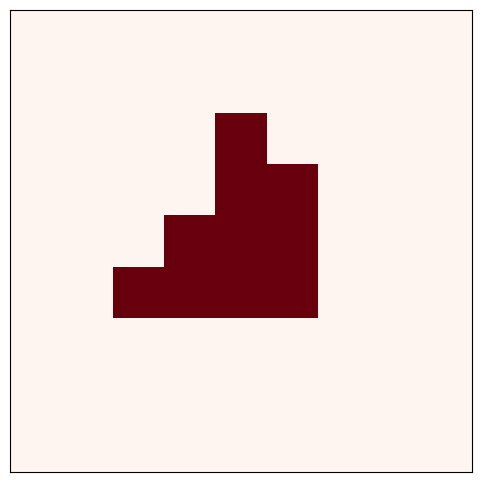

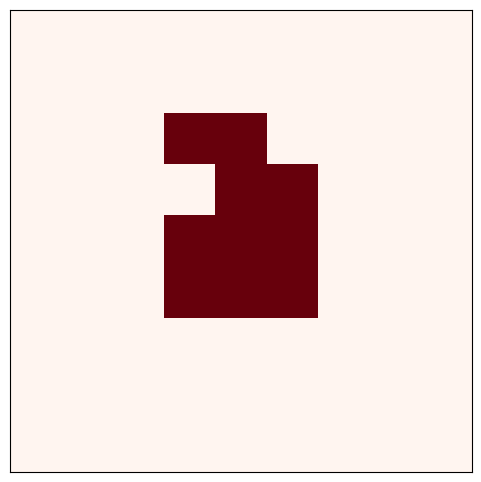

0


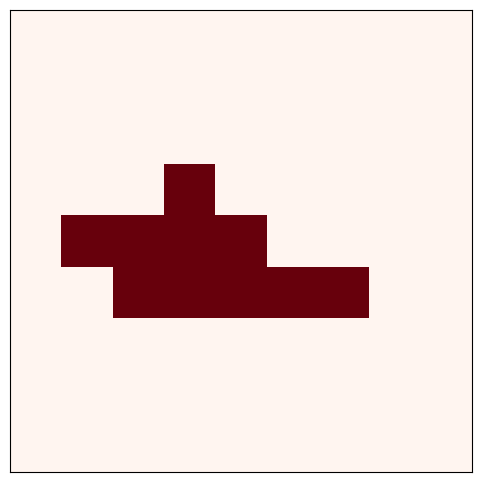

0


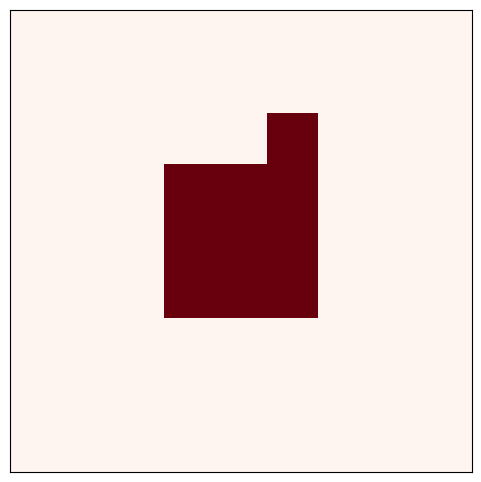

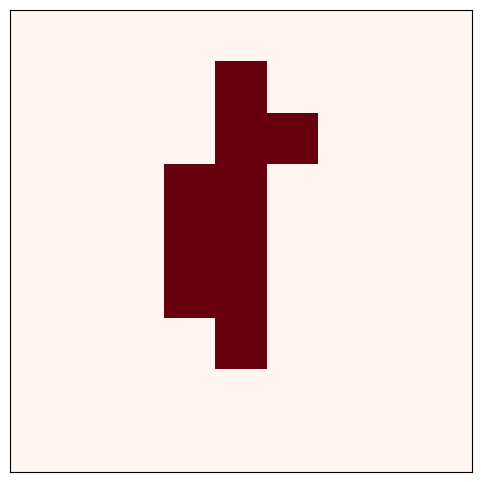

0


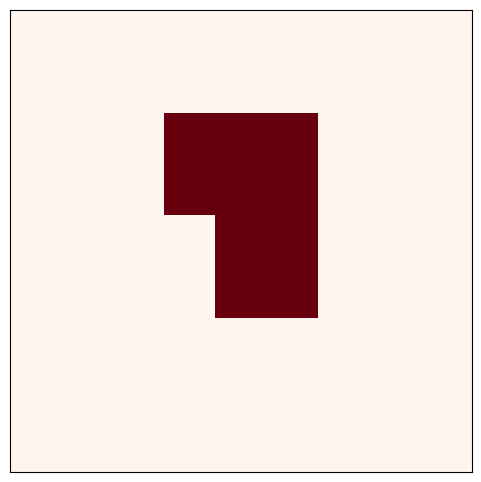

0


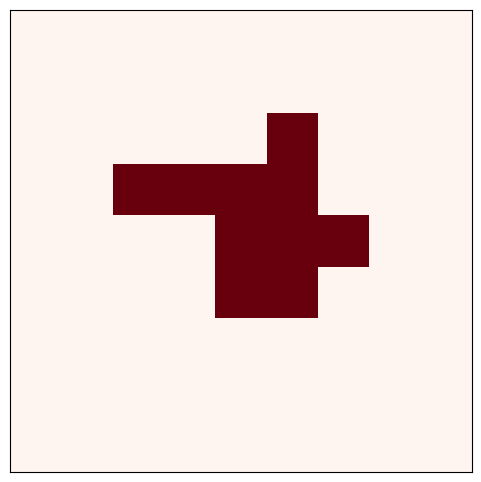

0


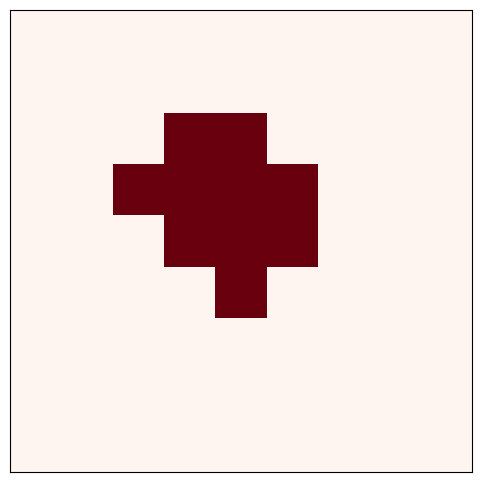

0


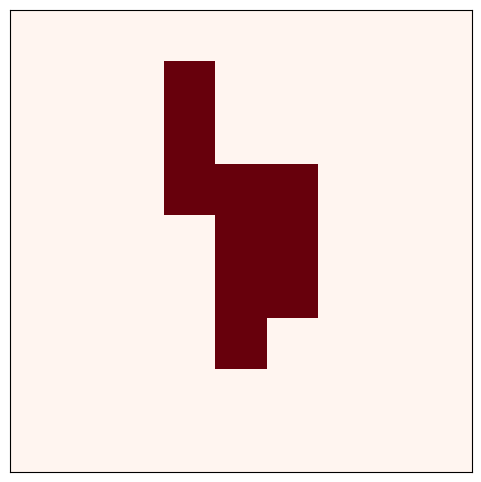

0


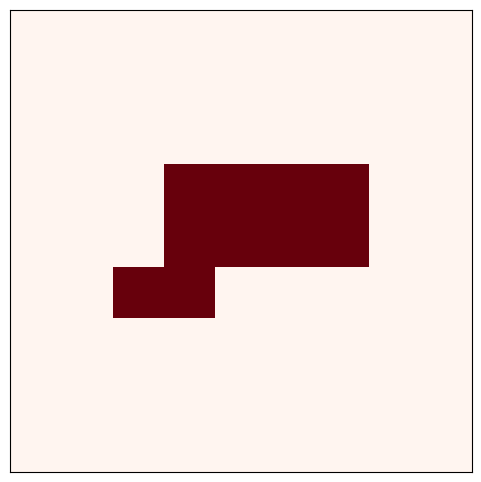

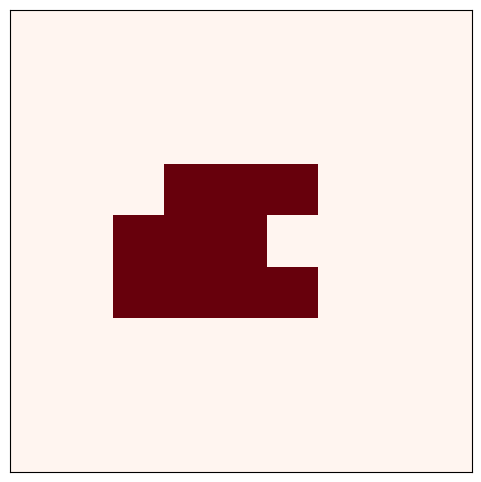

0


In [15]:

ended = True
while(len(my_shapes)<15):
    shape = generate_random_shape(10)
    shape= center_shape(shape)
    display_shape(shape)
    x = input()
    if(x == "9"):
        ended = False
    elif(x=="0"):
        my_shapes.append(shape)

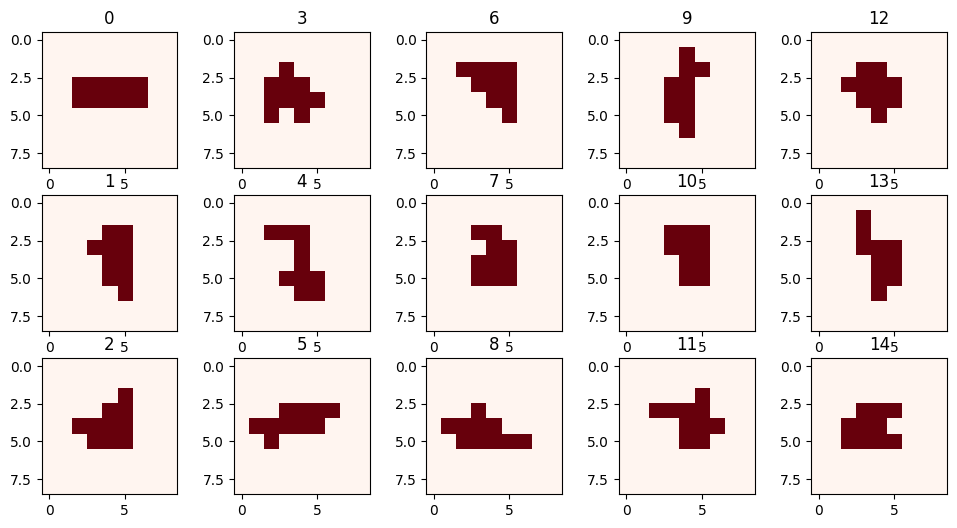

In [33]:

fig, axs = plt.subplots(3, 5, figsize=(12, 6))
cptx,cpty=0,0
cpttot = 0
for s in my_shapes:
    display_shape(s,ax=axs[cptx][cpty])
    axs[cptx][cpty].set_title(cpttot)
    cpttot+=1
    cptx+=1
    if(cptx==3):
        cpty+=1
        cptx=0
plt.show()

In [31]:
while(len(my_shapes)>15):
    sc = compare_shapes(my_shapes)
    mean_values = {typeA: sum(values.values()) for typeA, values in sc.items() if values}

    # Sort typeA keys by mean value in decreasing order
    sorted_keys = sorted(mean_values, key=mean_values.get, reverse=True)
    de = -1
    for c in range(len(my_shapes)):
        if(sorted_keys[0]==str(my_shapes[c])):
            d=c
    del my_shapes[d]

In [32]:
len(my_shapes)

15

In [35]:
shape_dict=dict()
shape_dict2=dict()

In [36]:
maxsim = len(my_shapes)/2

Found


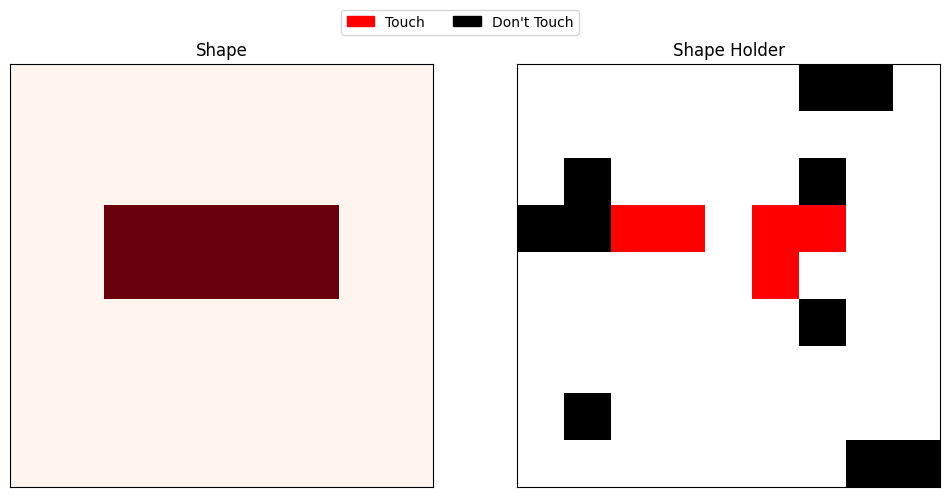

Found


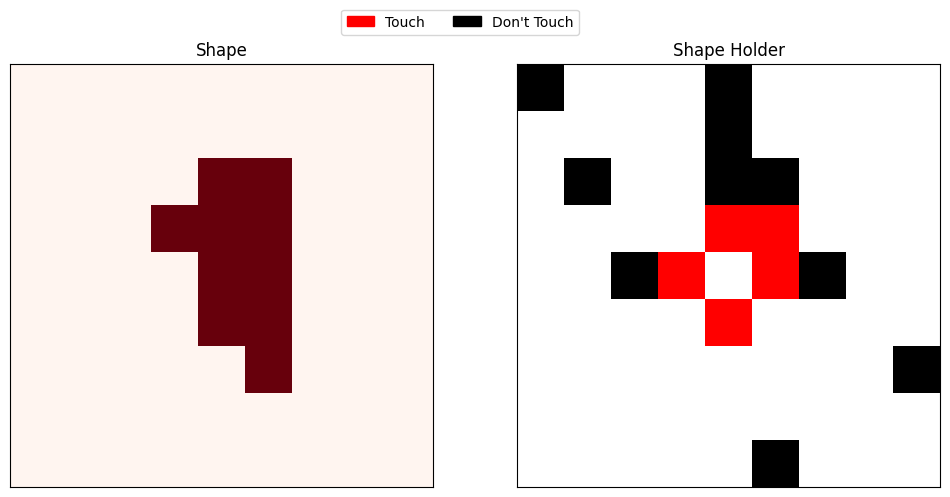

Found


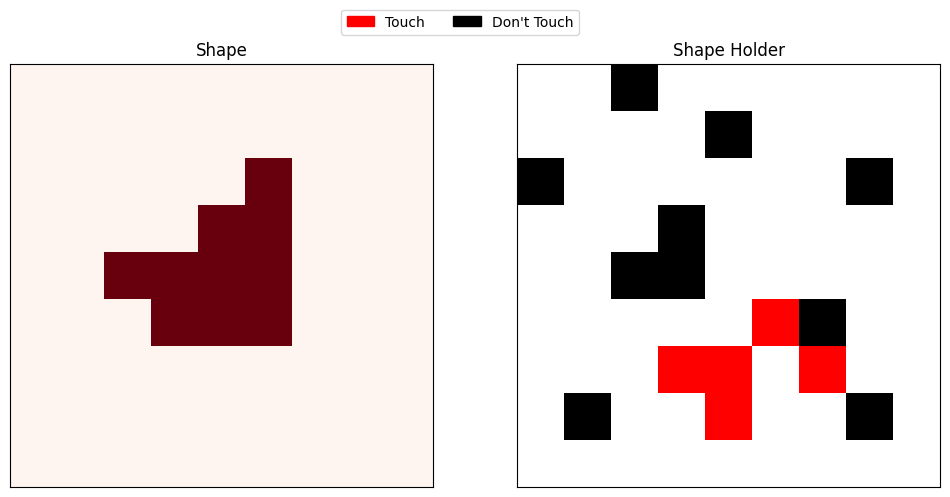

Found


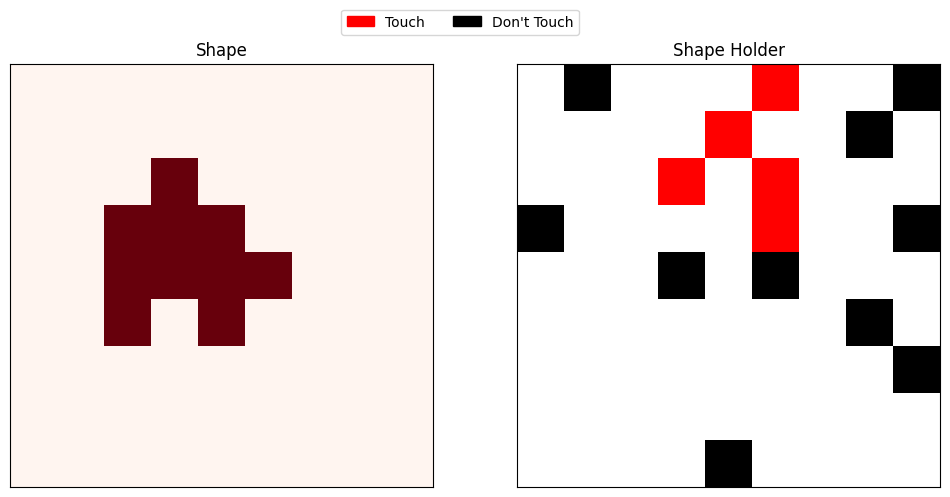

Found


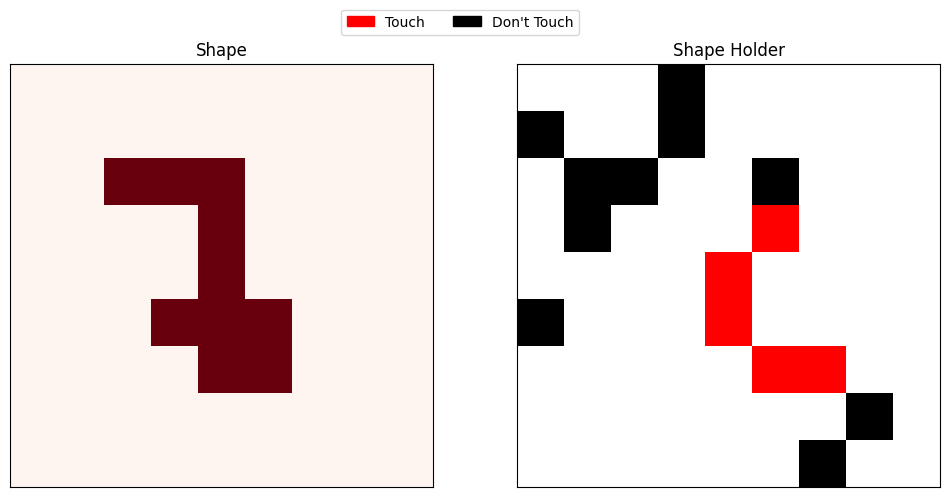

Found


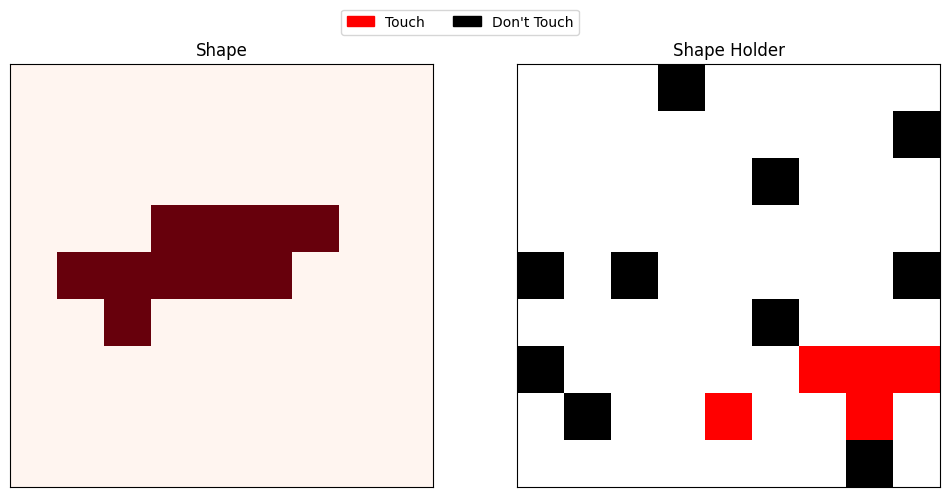

Found


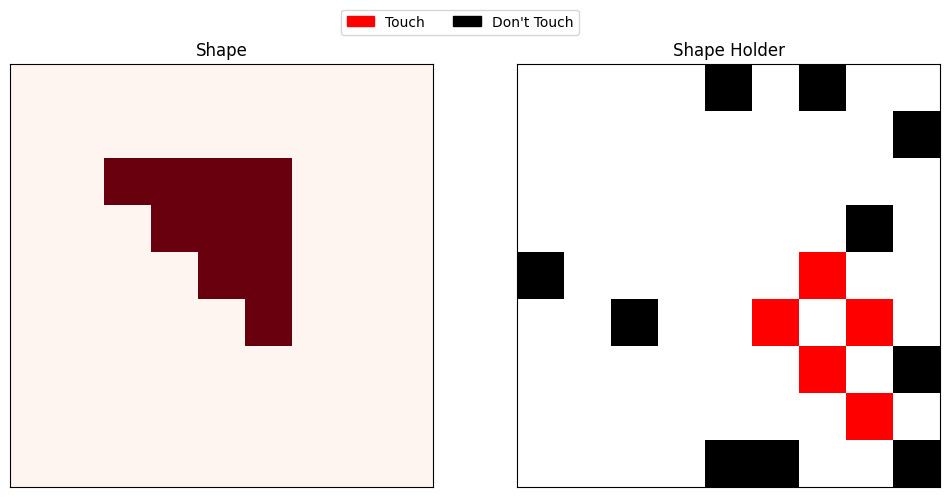

Found


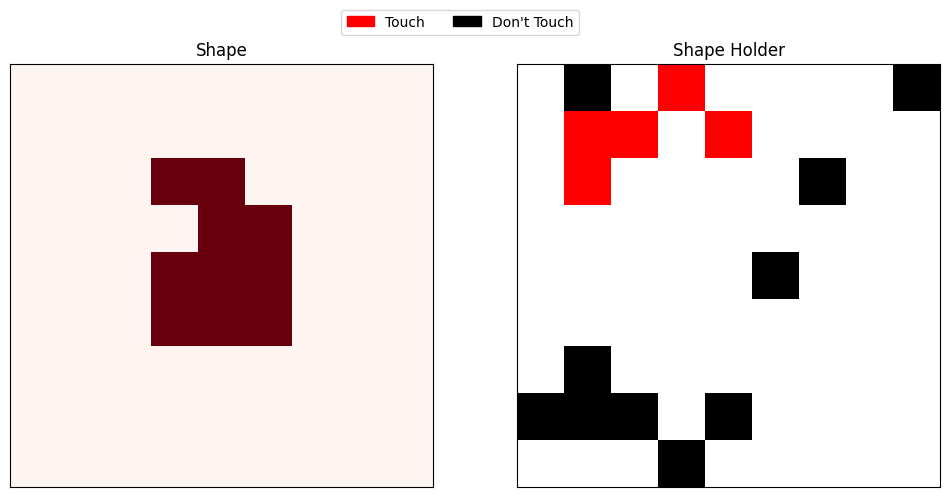

Found


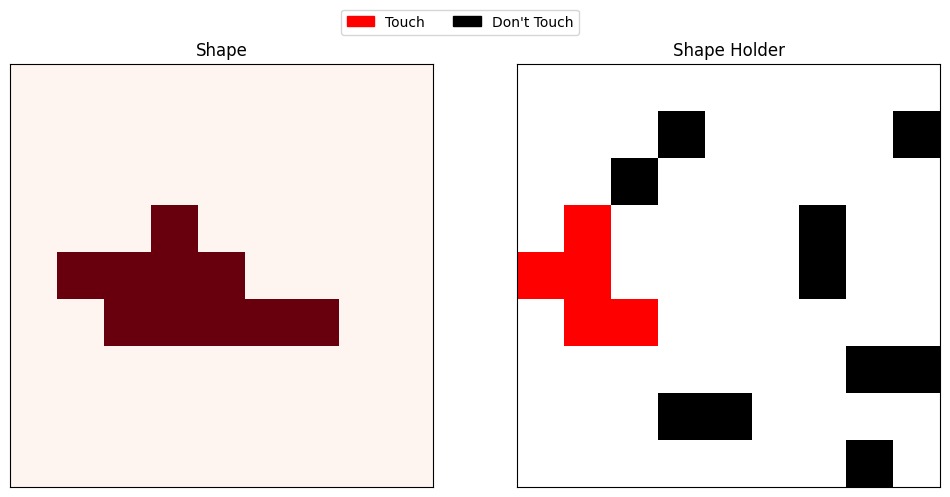

Found


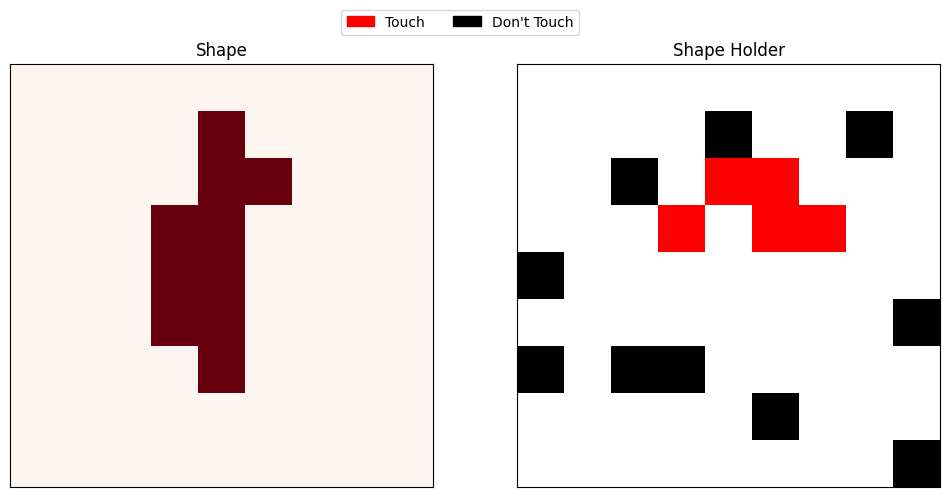

Found


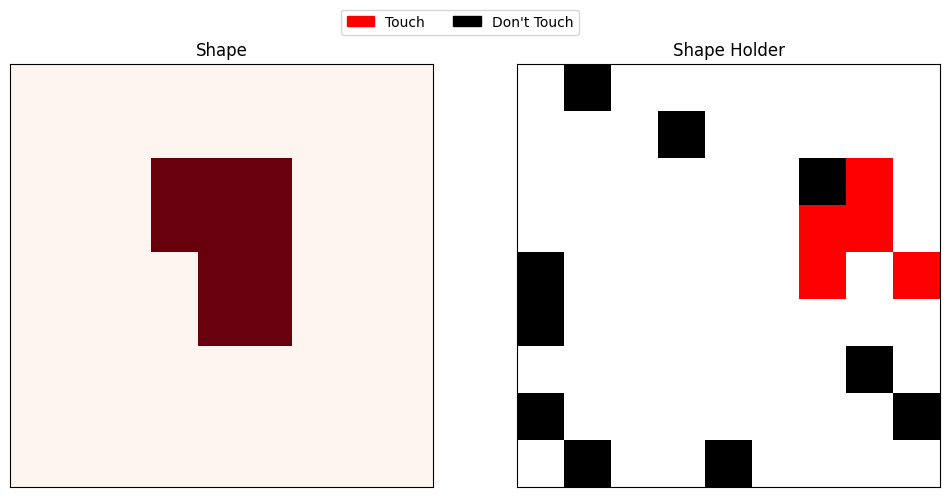

Found


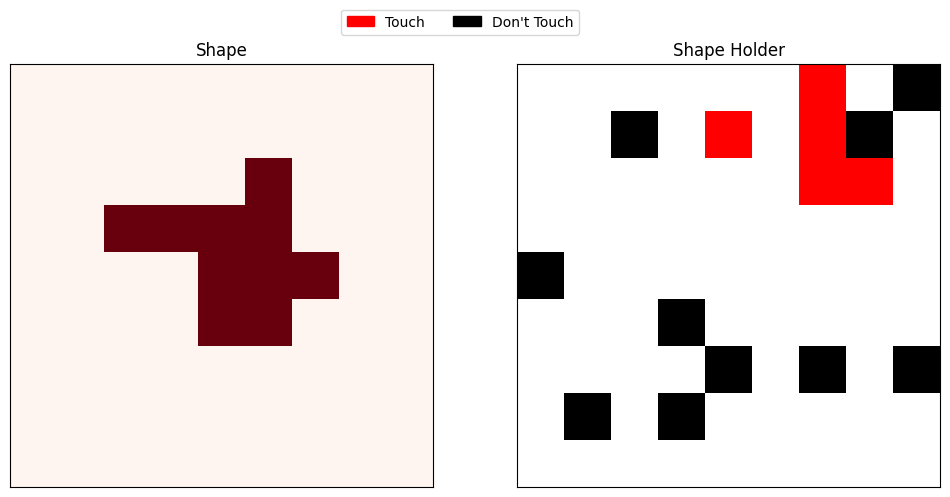

Found


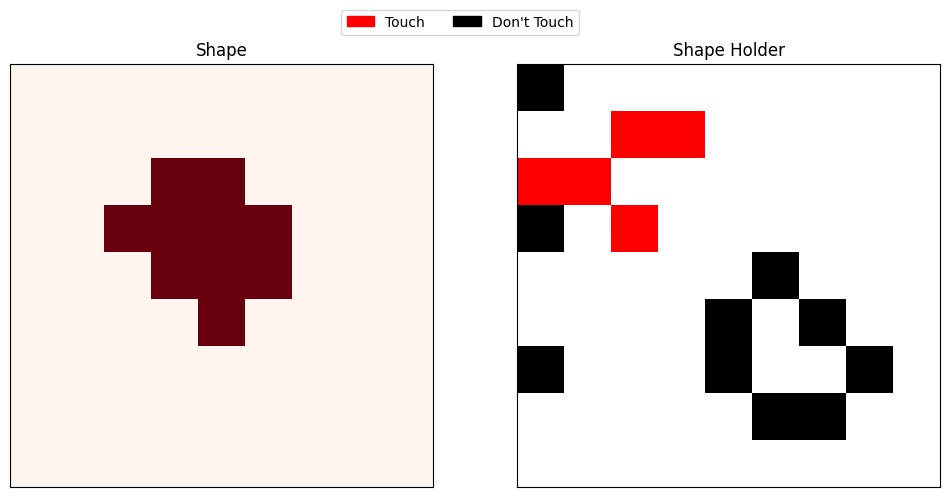

Found


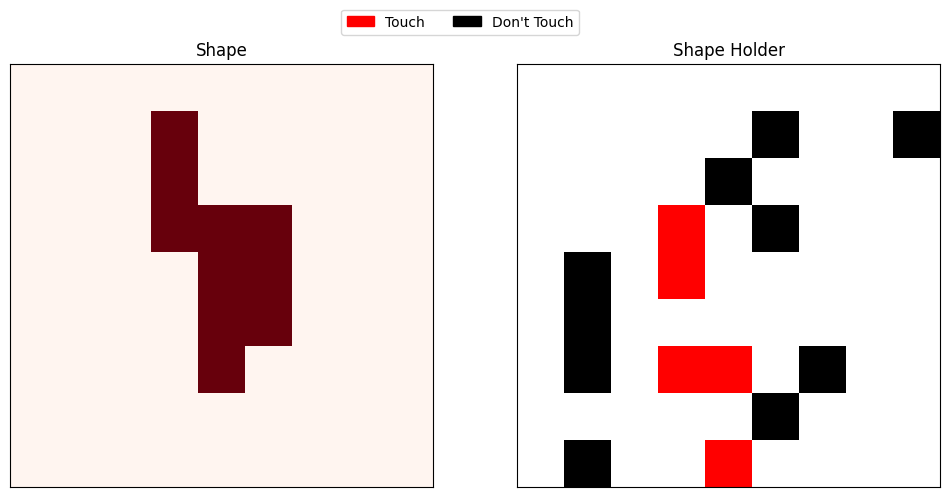

Found


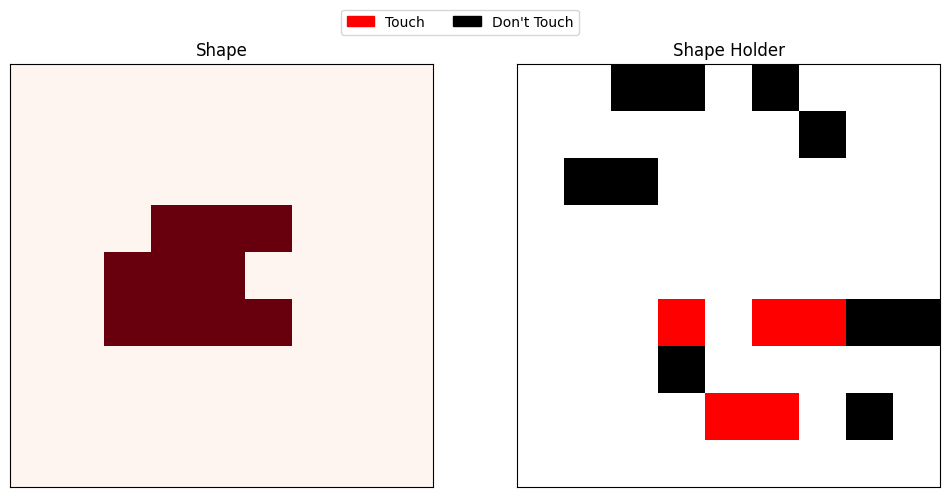

In [37]:

cptmax = 20000
for cshape in range(len(my_shapes)):
    if(str(my_shapes[cshape]) not in shape_dict.keys()):
        shape=my_shapes[cshape]
        found = False
        cpt = 0
        while(not found and cpt<cptmax):
            cpt+=1
            shape_holder = generate_shape_holder(5,10)  # Generate a 9x9 shape_holder
            foundHolder = checkAllAlignments(shape,shape_holder)
            c=0
            matchOther = 0
            while(c<len(my_shapes) and not matchOther):
                if(c != cshape):
                    if(checkAllAlignments(my_shapes[c],shape_holder)):
                        matchOther+=1
                c+=1
            found = foundHolder and (matchOther<maxsim)

        if(found):
            print("Found")
            shape_dict[str(shape)] = shape_holder
            display_shape_and_holder(shape,shape_holder)
        else:
            print("Impossible")
            display_shape(shape)
            

Found


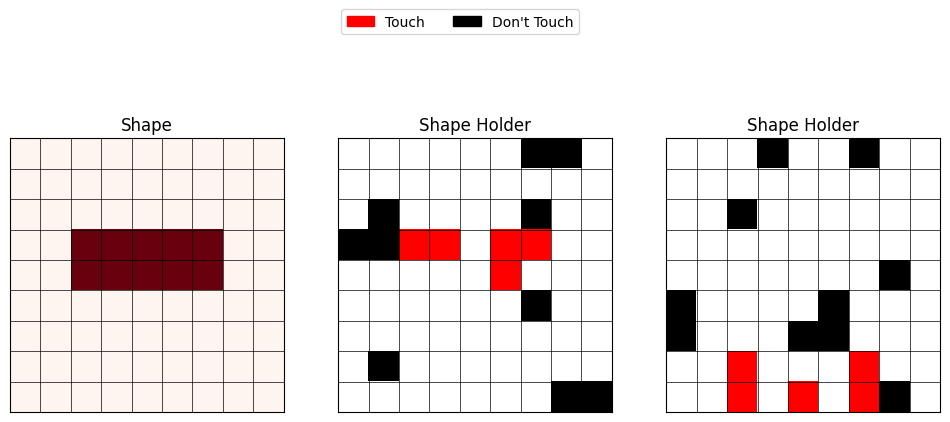

Found


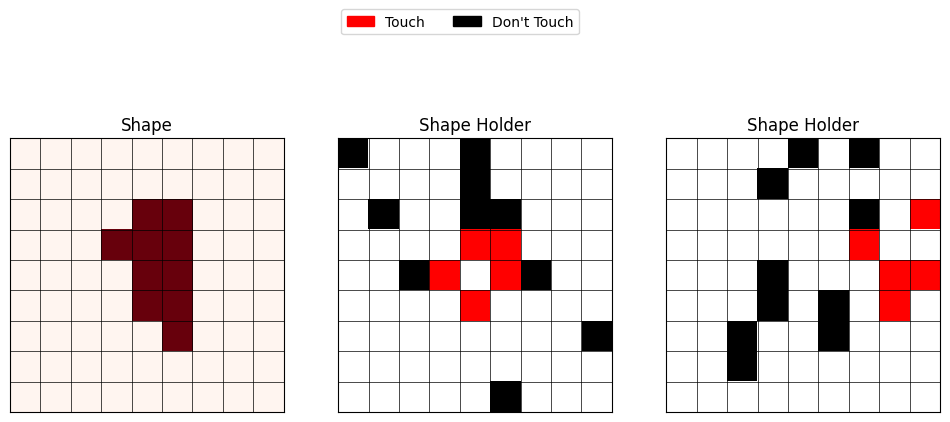

Found


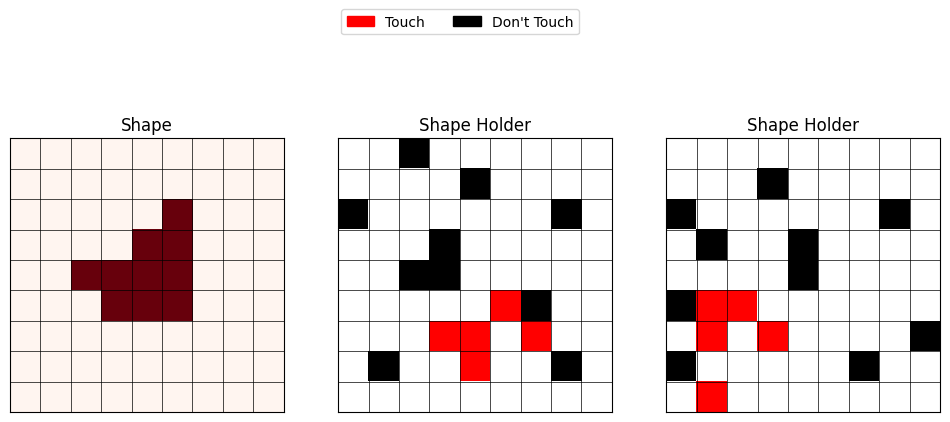

Found


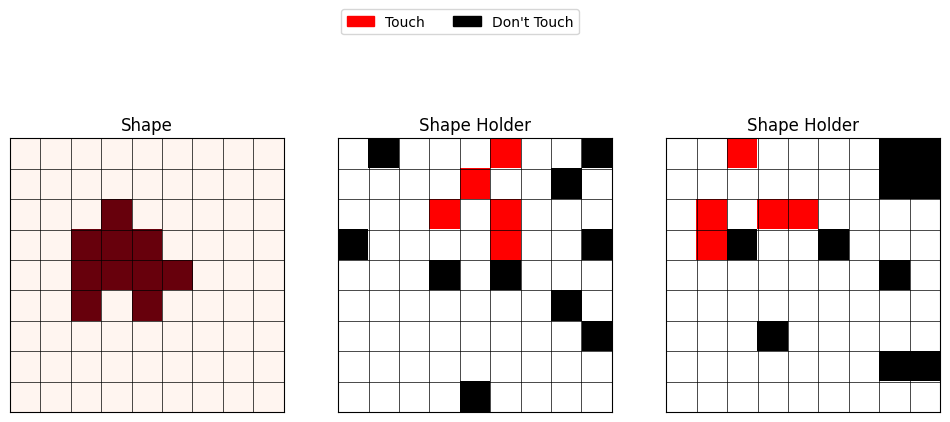

Found


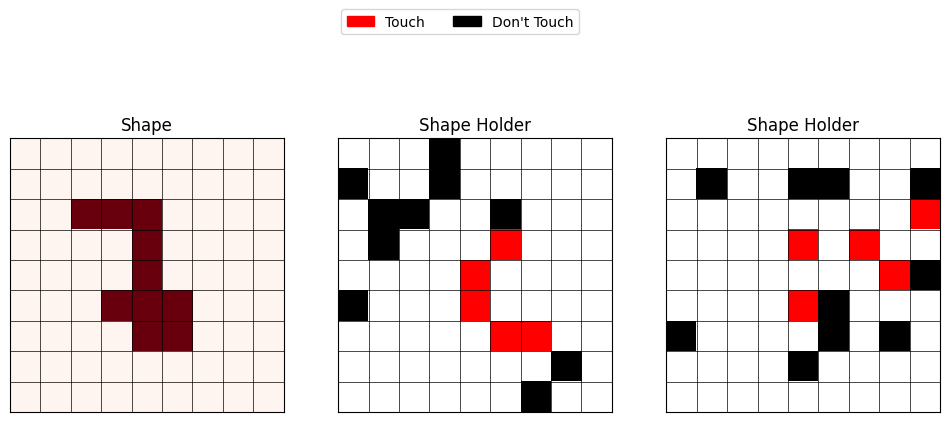

Found


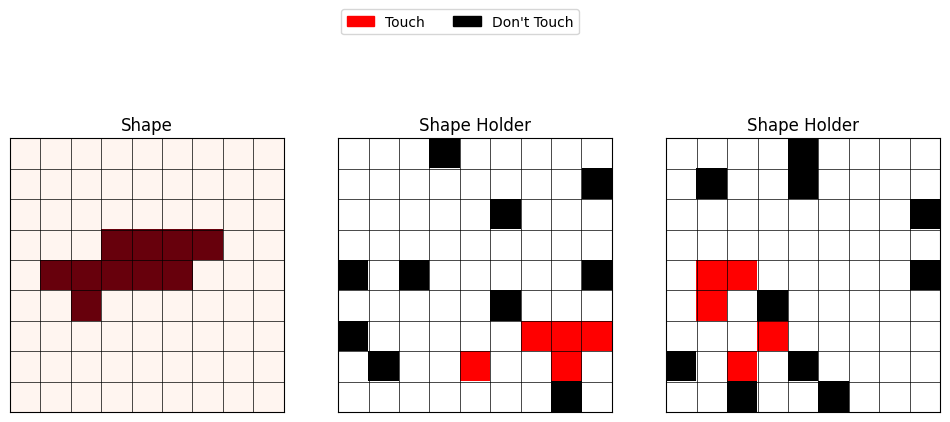

Found


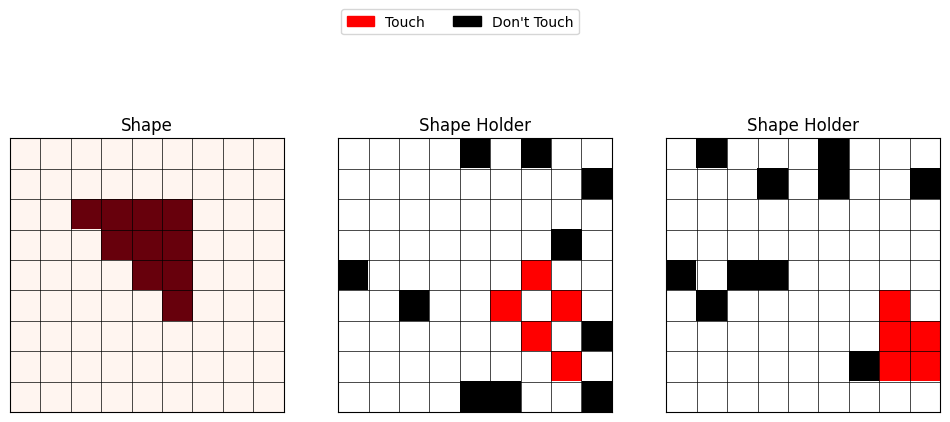

Found


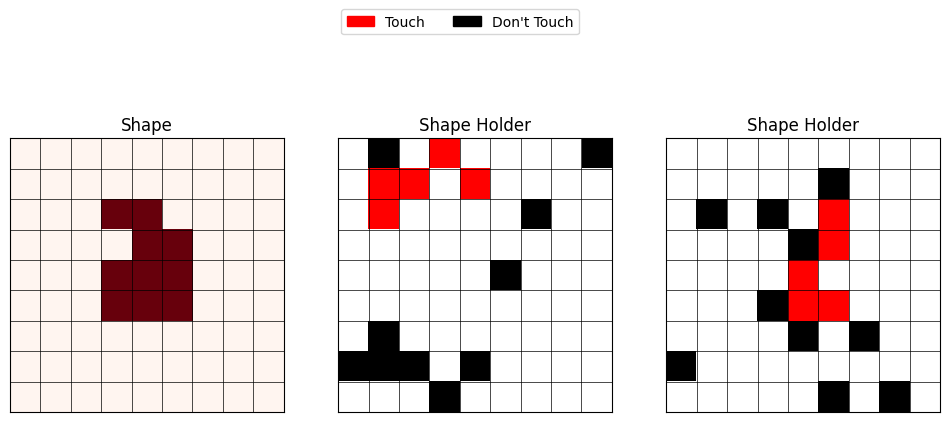

Found


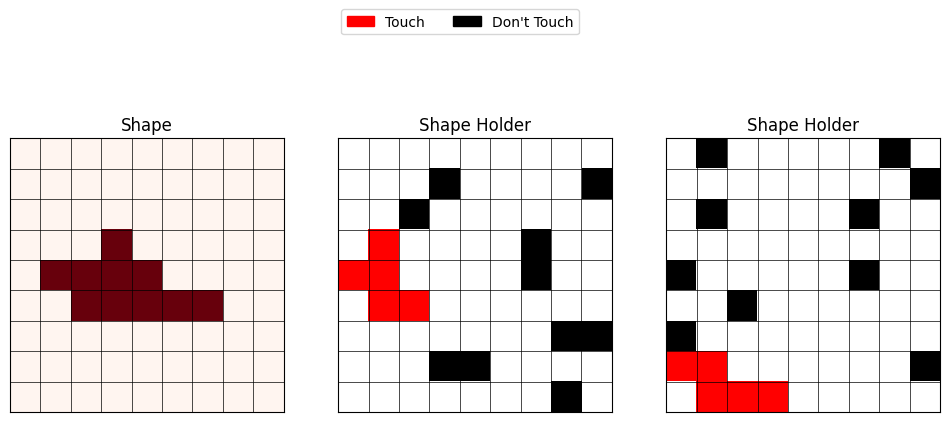

Found


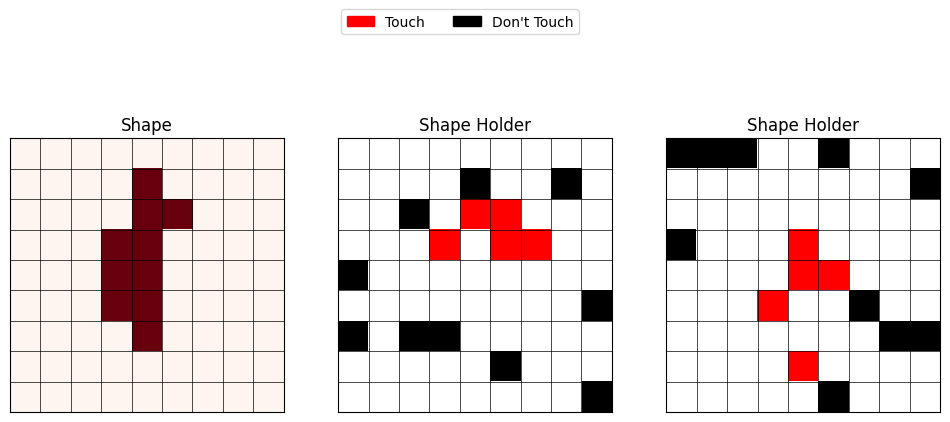

Found


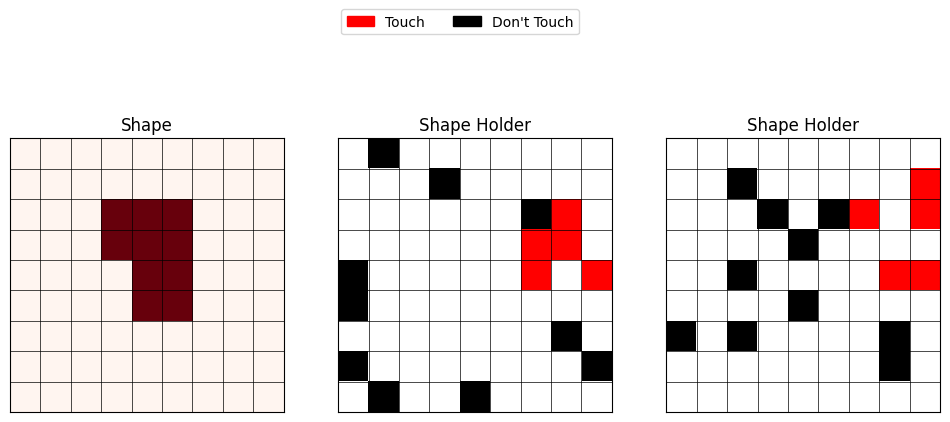

Found


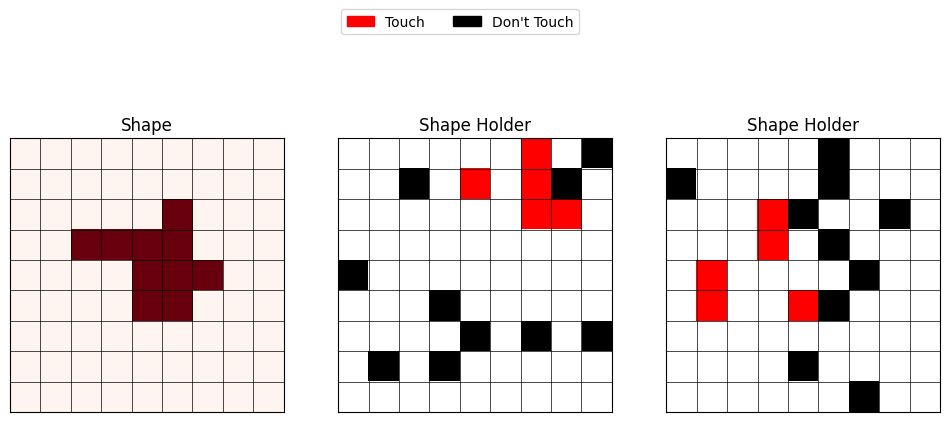

Found


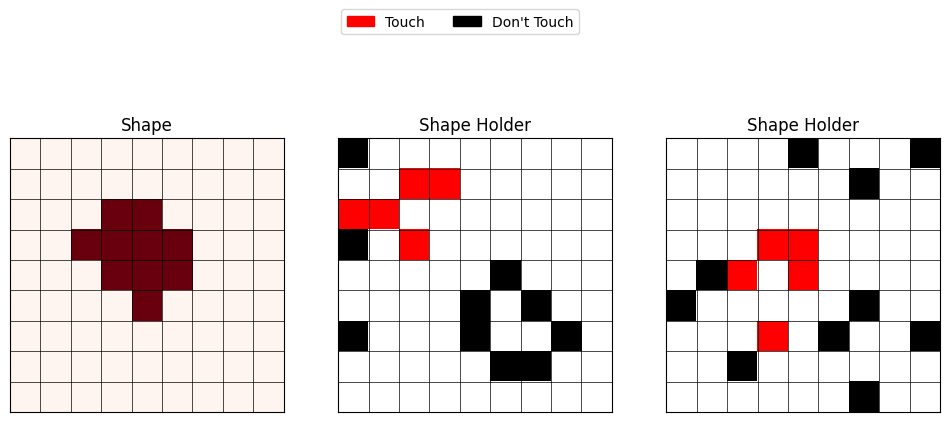

Found


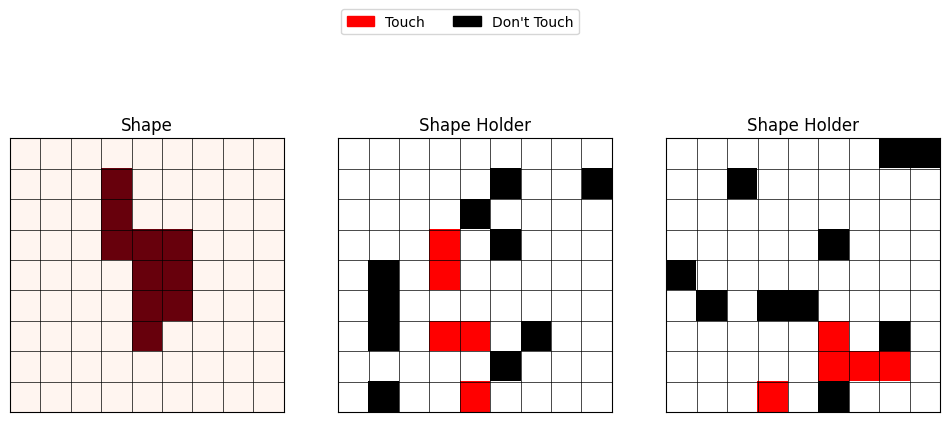

Found


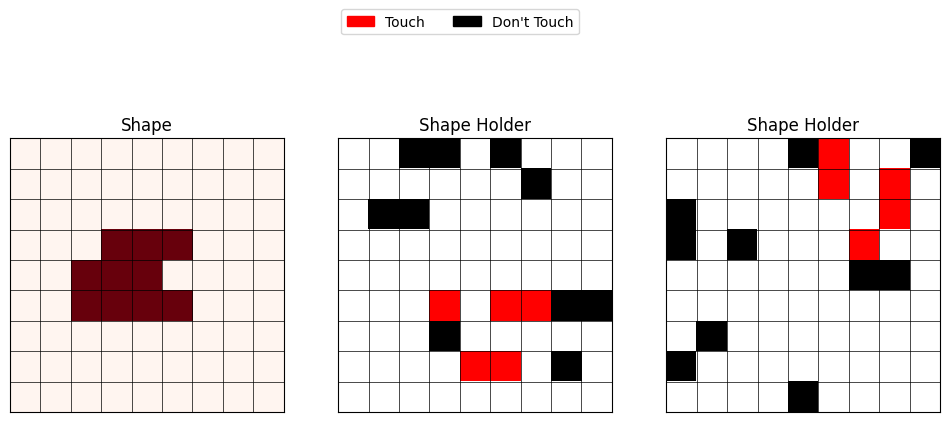

In [38]:
cptmax = 20000
for cshape in range(len(my_shapes)):
    if(str(my_shapes[cshape]) not in shape_dict2.keys()):
        shape=my_shapes[cshape]
        found = False
        cpt = 0
        while(not found and cpt<cptmax):
            cpt+=1
            shape_holder = generate_shape_holder(5,10)  # Generate a 9x9 shape_holder
            foundHolder = checkAllAlignments(shape,shape_holder)
            c=0
            matchOther = 0
            while(c<len(my_shapes) and not matchOther):
                if(c != cshape):
                    if(checkAllAlignments(my_shapes[c],shape_holder)):
                        matchOther+=1
                c+=1
            found = foundHolder and (matchOther<maxsim) and str(shape_holder) != str(shape_dict[str(shape)])

        if(found):
            print("Found")
            shape_dict2[str(shape)] = shape_holder
            display_shape_and_holder2(shape,shape_dict[str(shape)],shape_holder)
        else:
            print("Impossible")
            display_shape(shape)
            

In [33]:
xx = 0
for c in range(len(my_shapes)):
    if(str(shape)==str(my_shapes[c])):
        xx = c


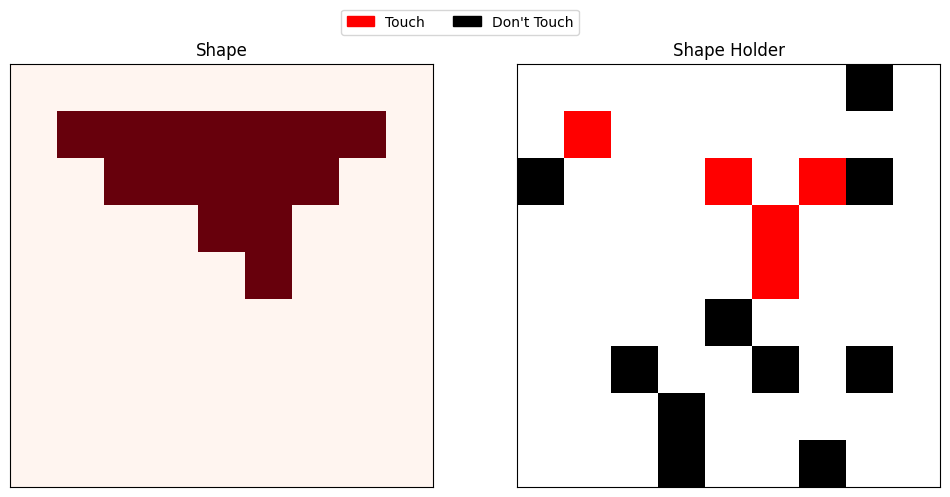

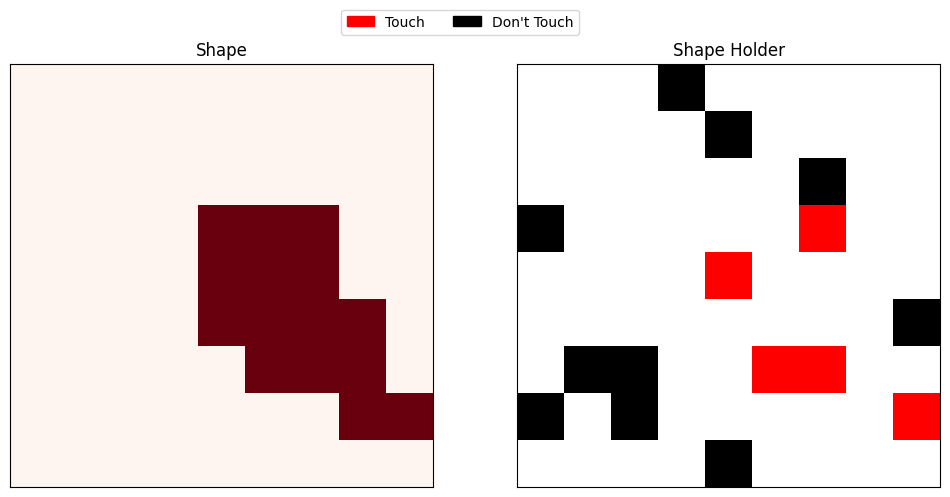

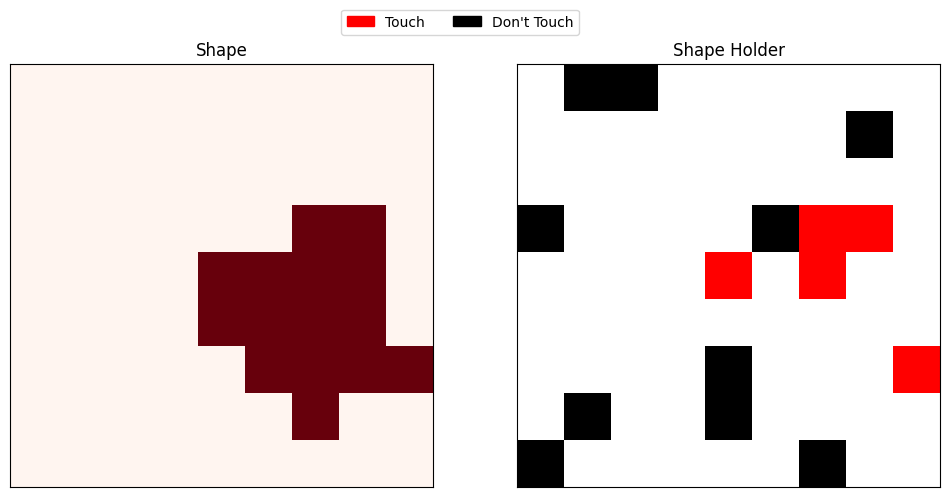

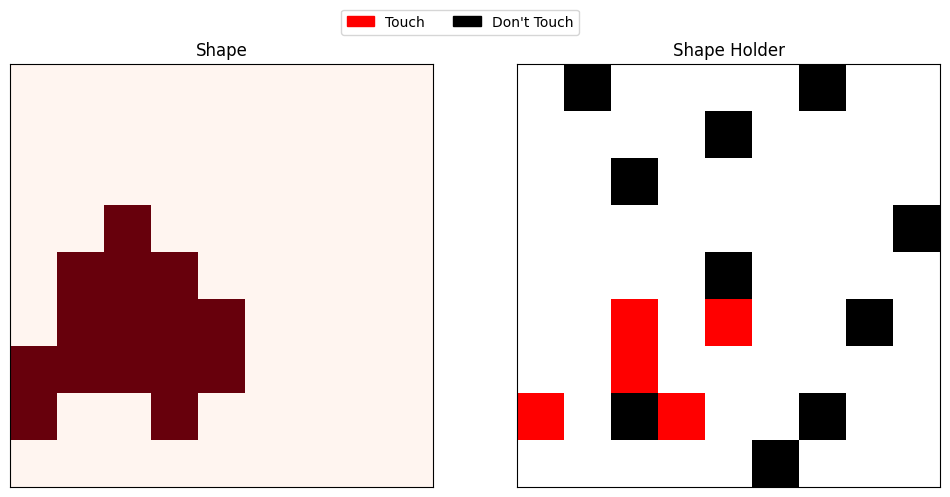

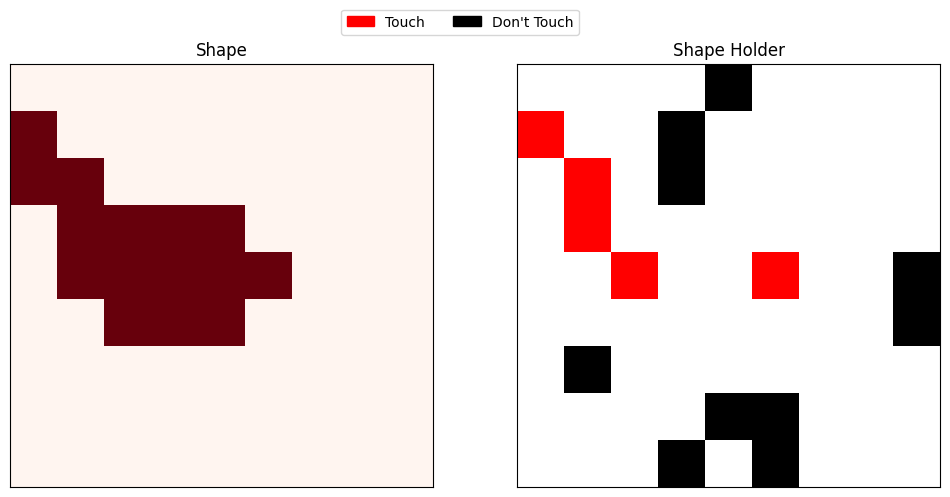

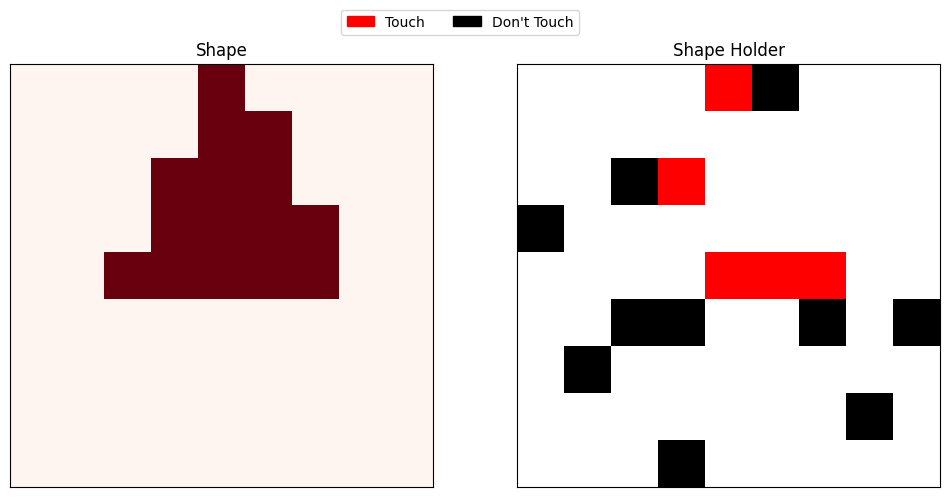

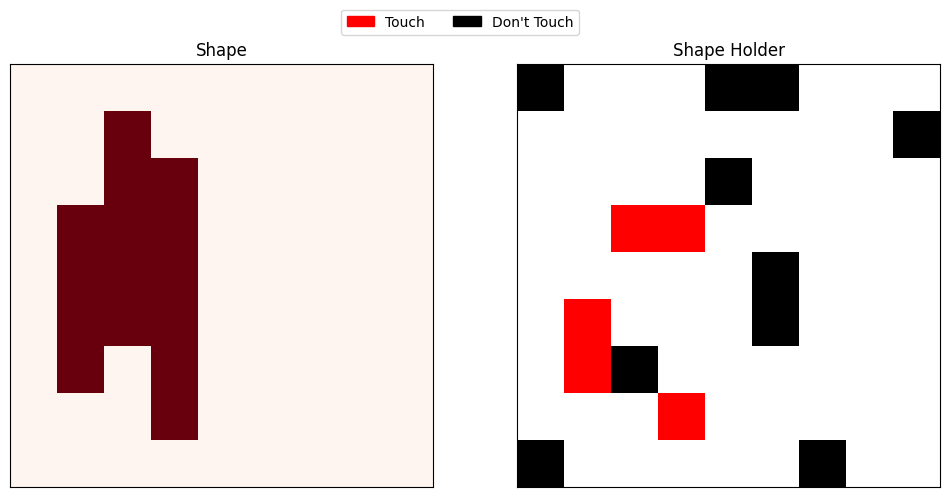

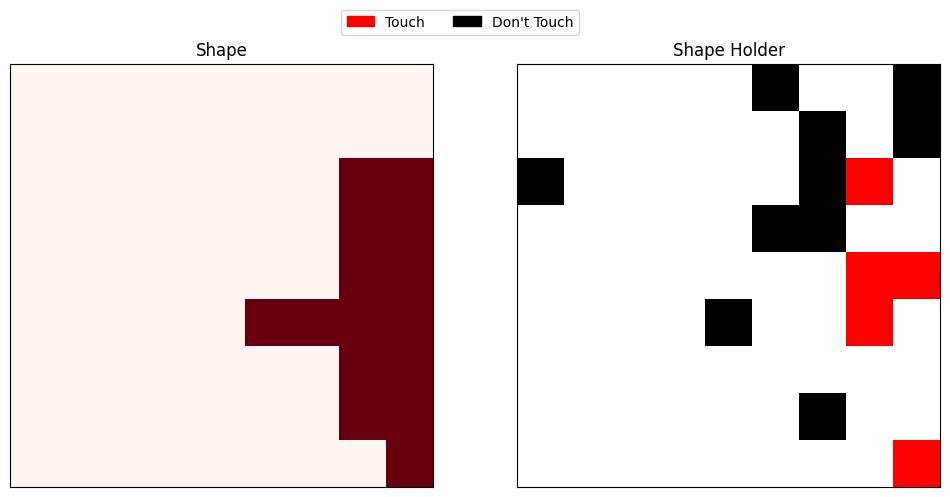

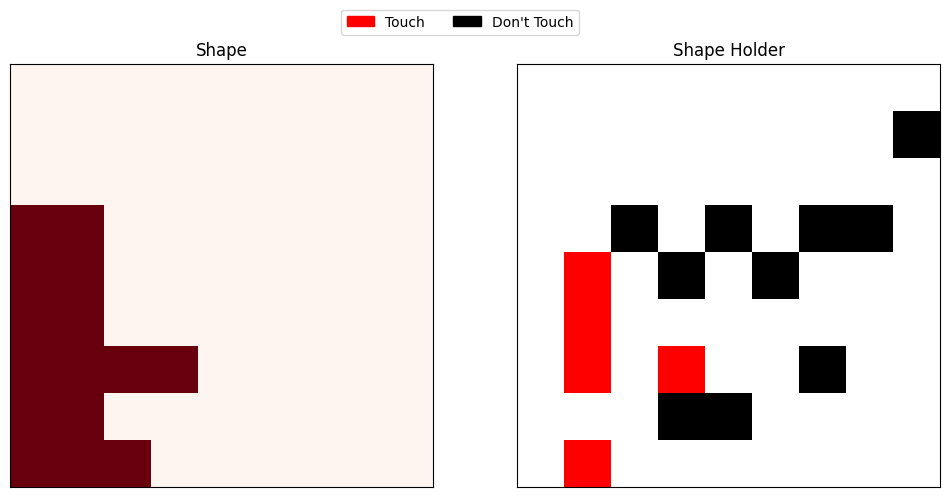

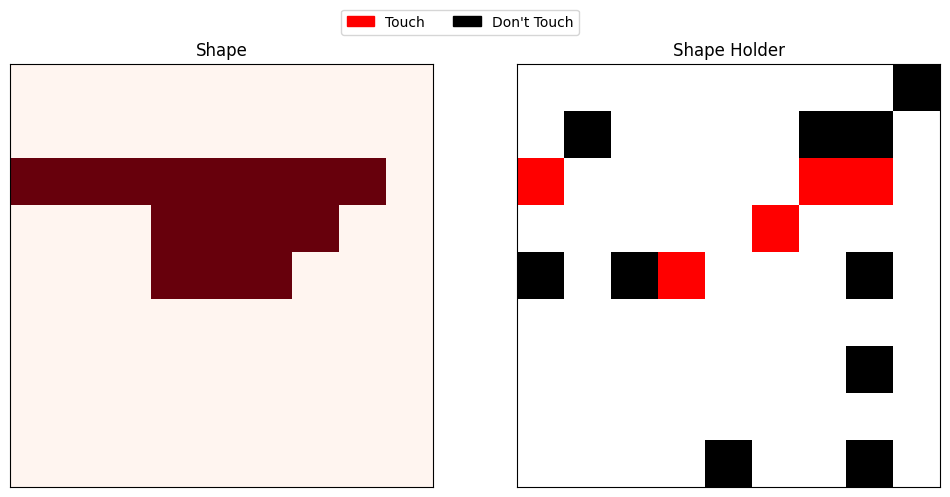

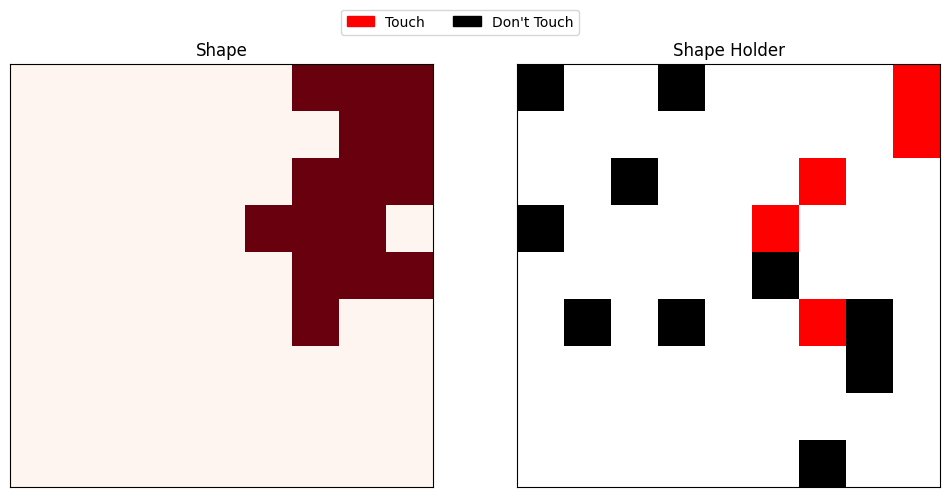

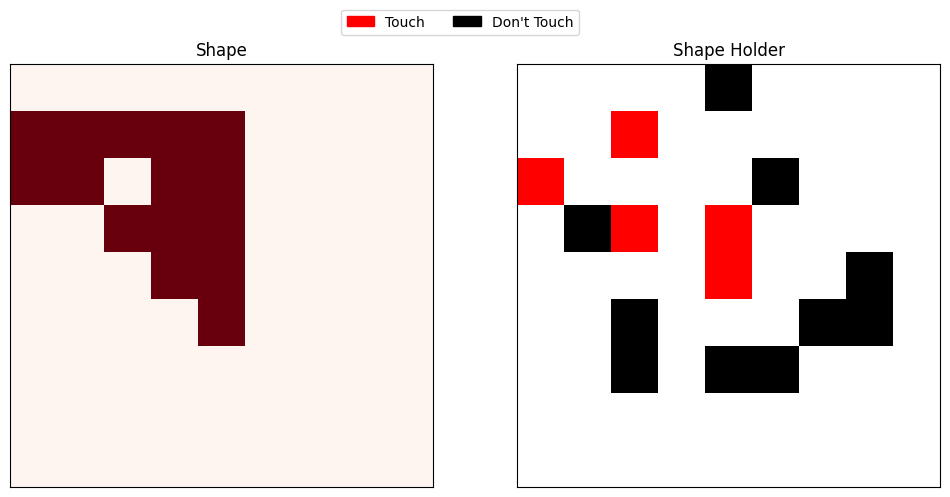

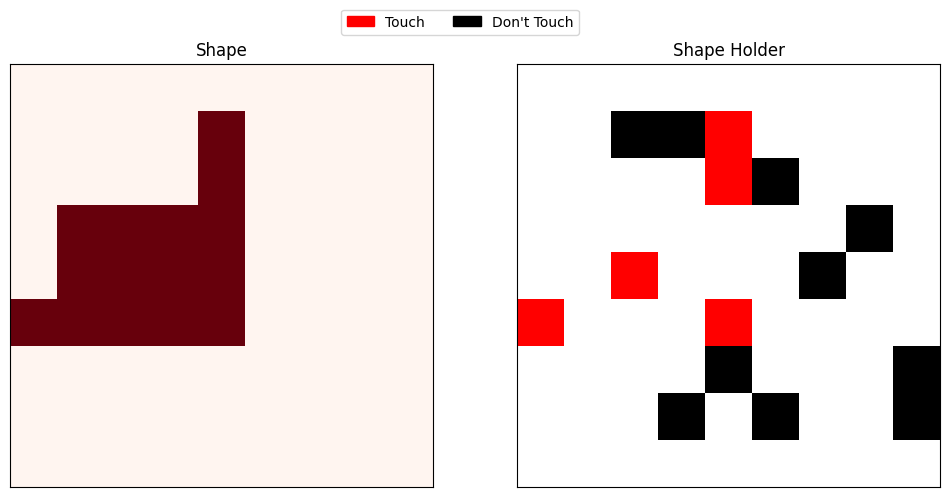

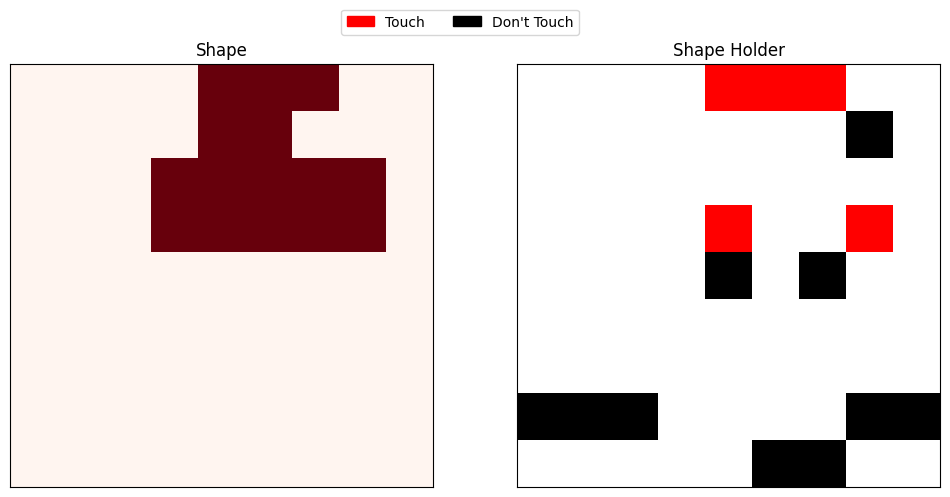

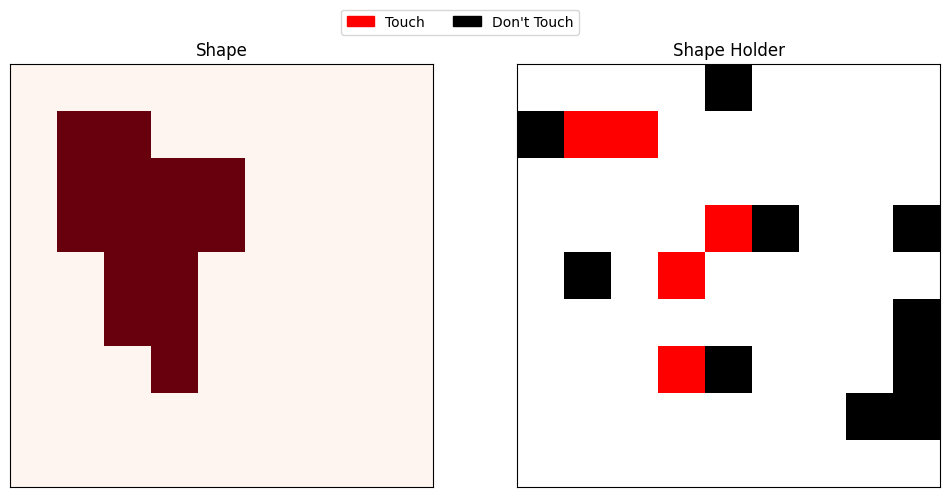

In [34]:
for shapetxt in shape_dict:
    shape_holder = shape_dict[shapetxt]
    shape = string_to_array(shapetxt)
    shape = getAlignment(shape,shape_holder)
    display_shape_and_holder(shape,shape_holder)

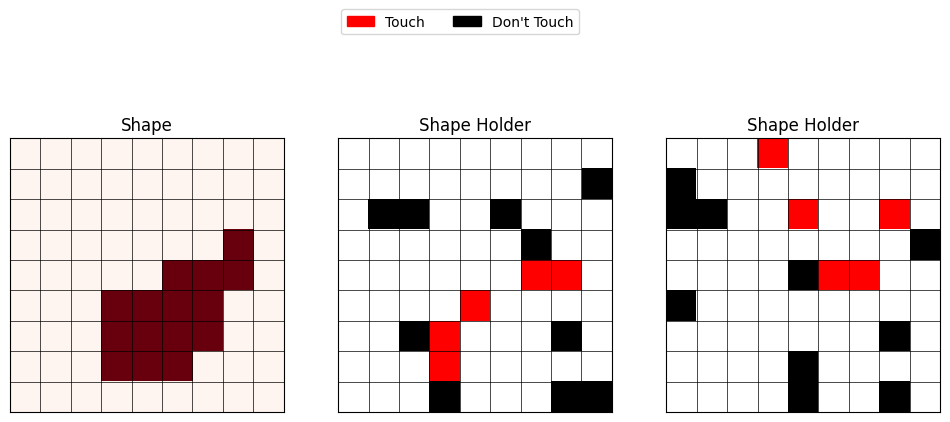

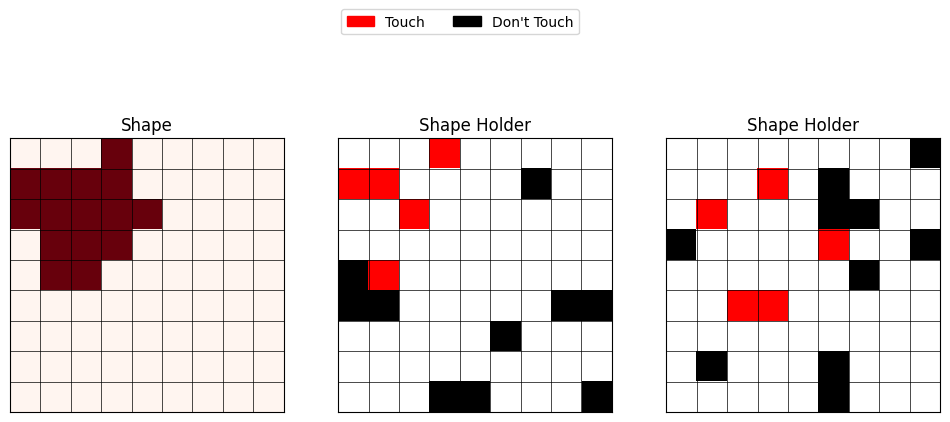

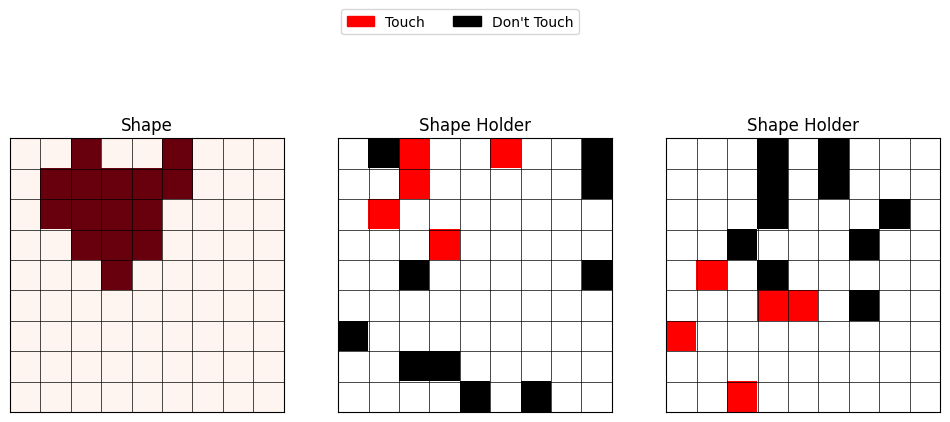

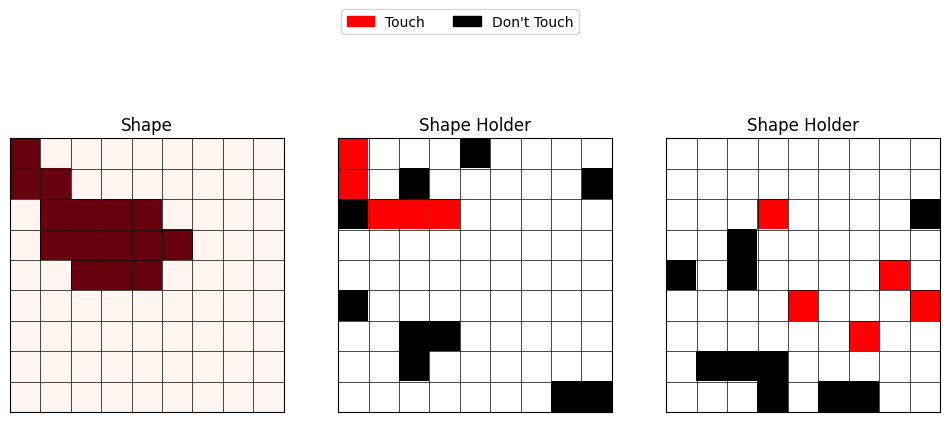

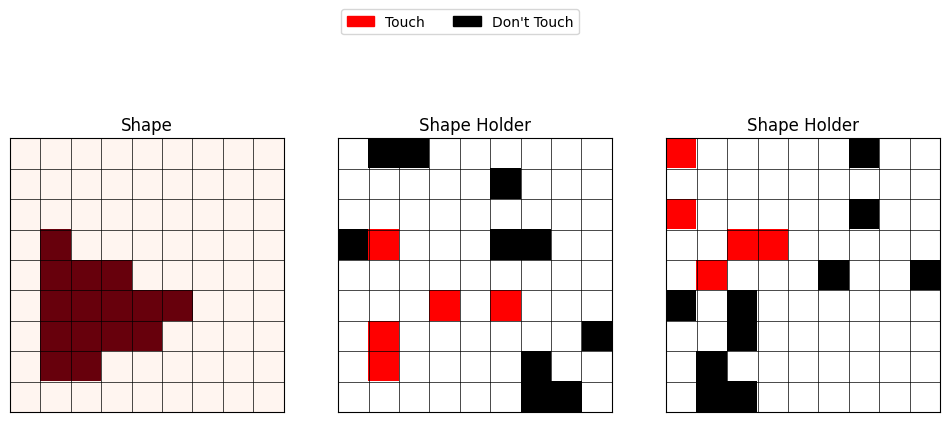

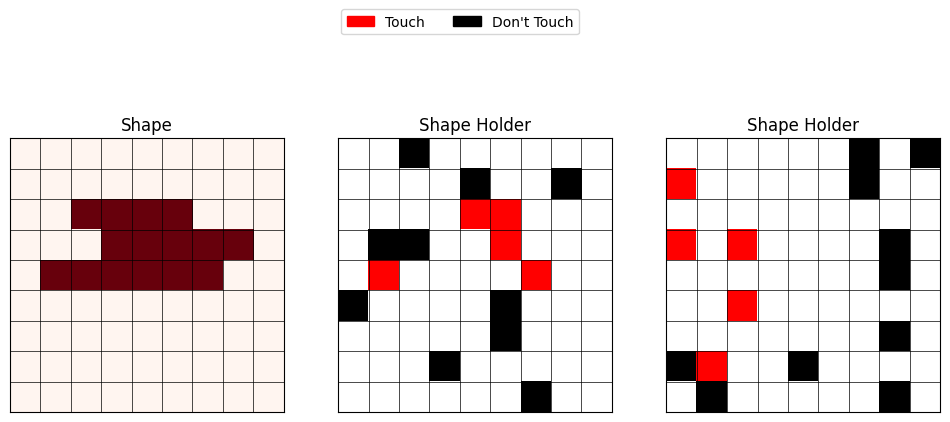

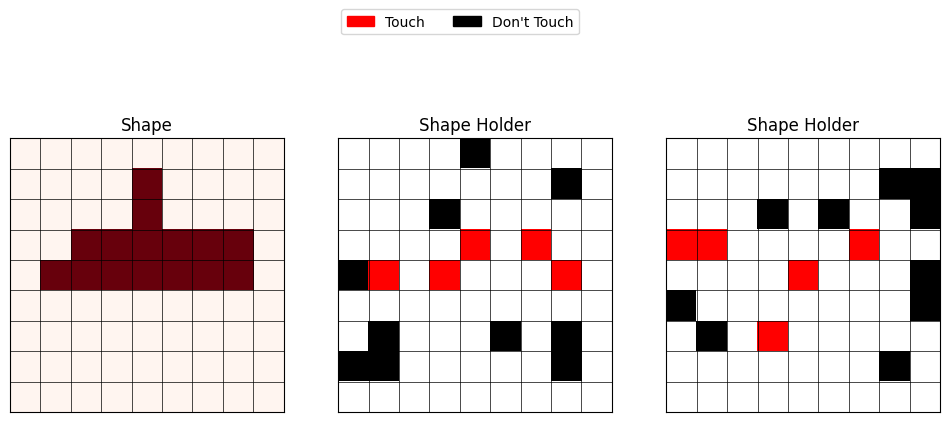

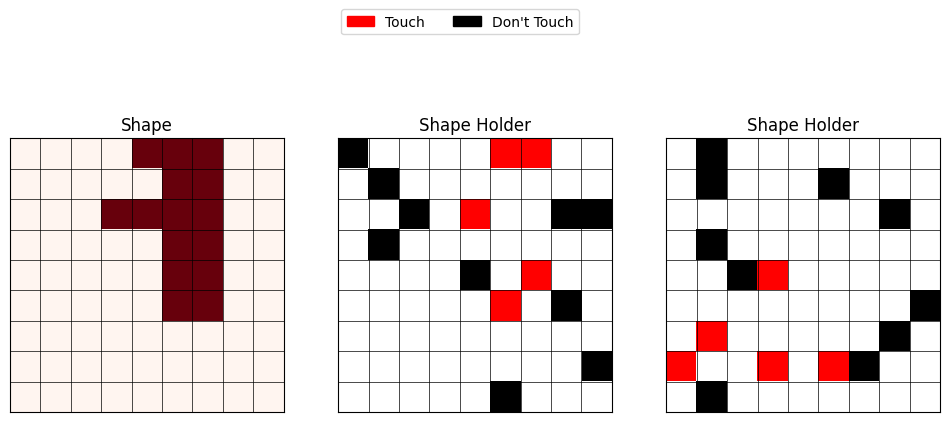

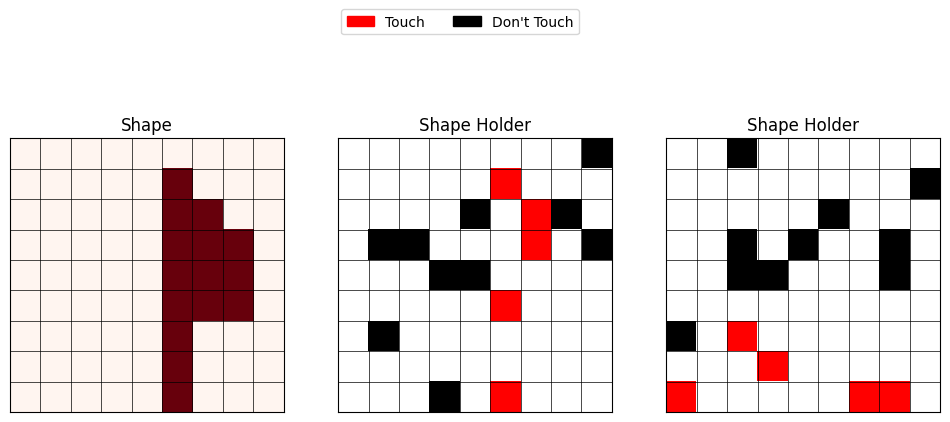

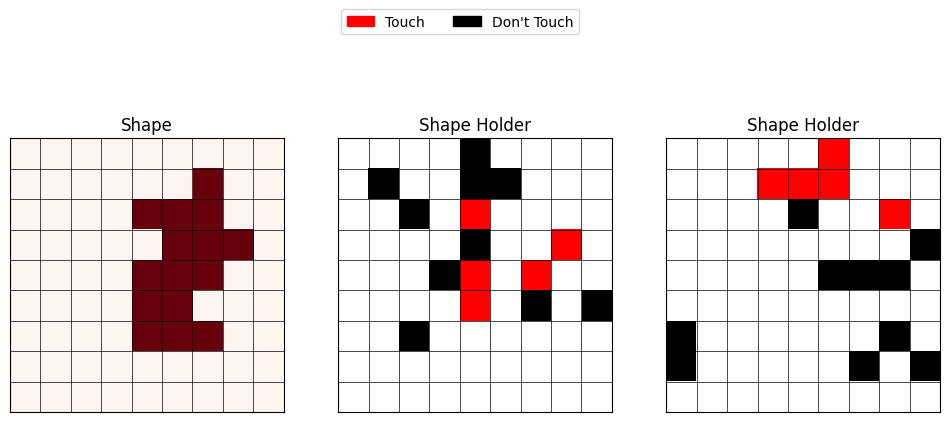

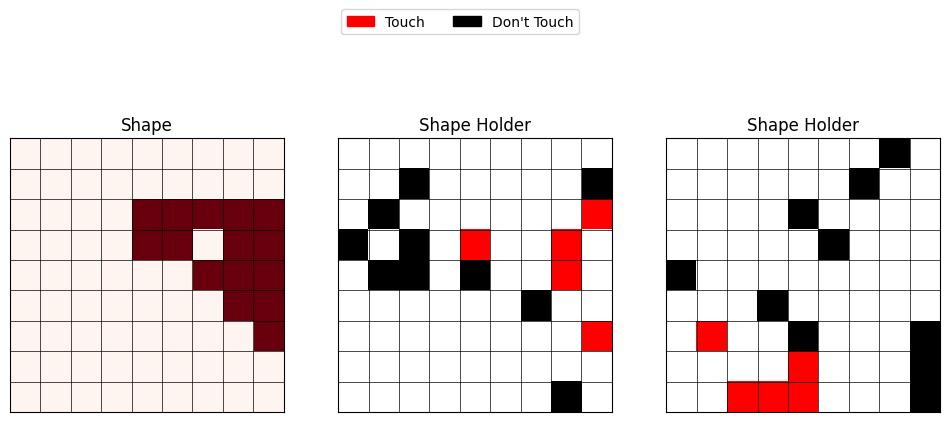

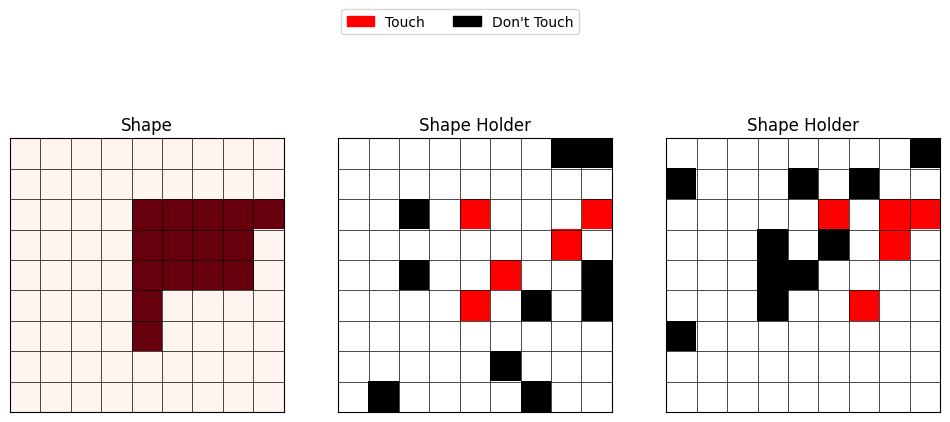

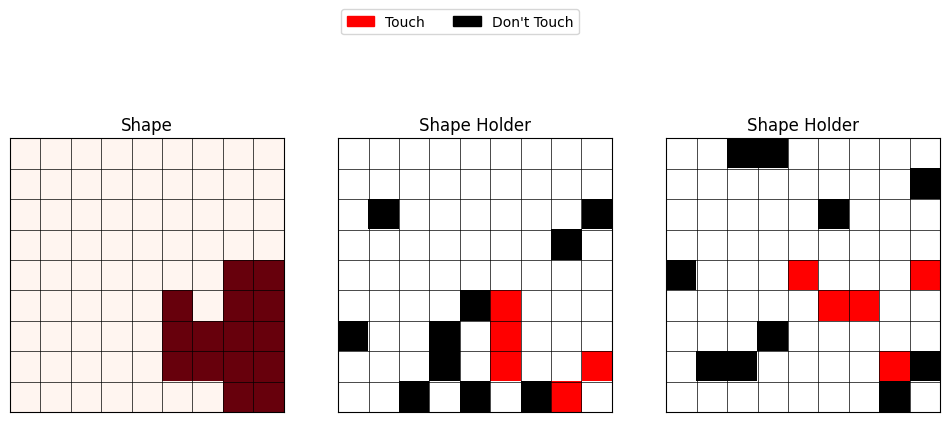

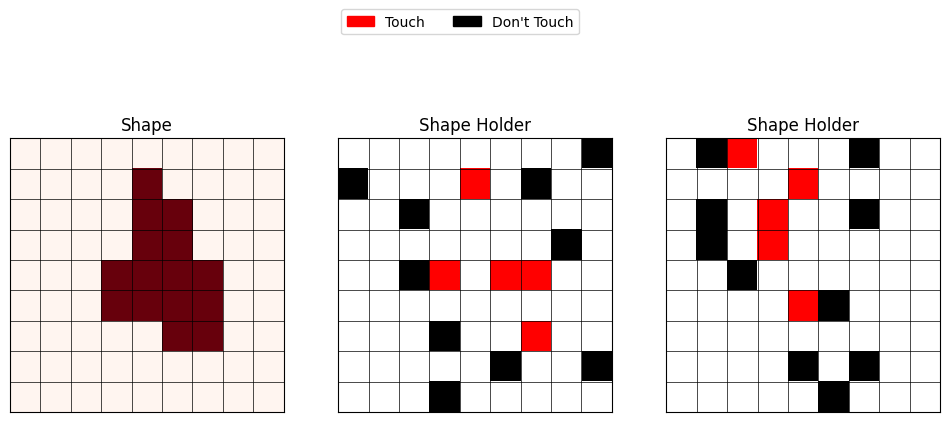

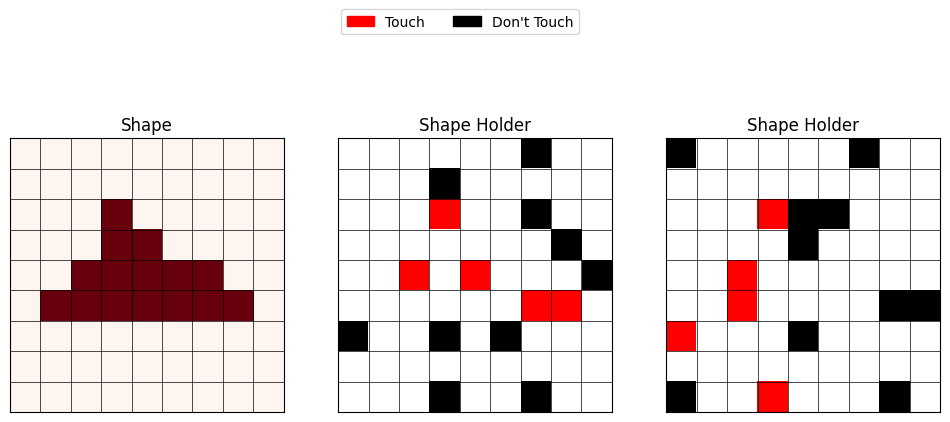

In [47]:
for shapetxt in shape_dict:
    shape_holder = shape_dict[shapetxt]
    shape_holder2 = shape_dict2[shapetxt]
    shape = string_to_array(shapetxt)
    shape = getAlignment(shape,shape_holder)
    display_shape_and_holder2(shape,shape_holder,shape_holder2)

In [48]:
len(my_shapes)

15

In [42]:
def save_shapes_dict(shapes_dict, filename):
    """
    Saves a dictionary of shapes and shape holders to a file.

    Parameters:
    - shapes_dict: dict, keys are string representations of shapes, values are numpy arrays (shape holders)
    - filename: str, path to the file where the dictionary will be saved
    """
    with open(filename, 'wb') as file:
        pickle.dump(shapes_dict, file)
    print(f"Shapes dictionary saved to {filename}")

def load_shapes_dict(filename):
    """
    Loads a dictionary of shapes and shape holders from a file.

    Parameters:
    - filename: str, path to the file from which the dictionary will be loaded
    
    Returns:
    - dict, where keys are string representations of shapes, and values are numpy arrays (shape holders)
    """
    with open(filename, 'rb') as file:
        shapes_dict = pickle.load(file)
    print(f"Shapes dictionary loaded from {filename}")
    return shapes_dict


# Save the dictionary to a file
save_shapes_dict(shape_dict, "shapes_dict5.pkl")

# Load the dictionary from the file
loaded_shapes_dict = load_shapes_dict("shapes_dict5.pkl")

Shapes dictionary saved to shapes_dict5.pkl
Shapes dictionary loaded from shapes_dict5.pkl


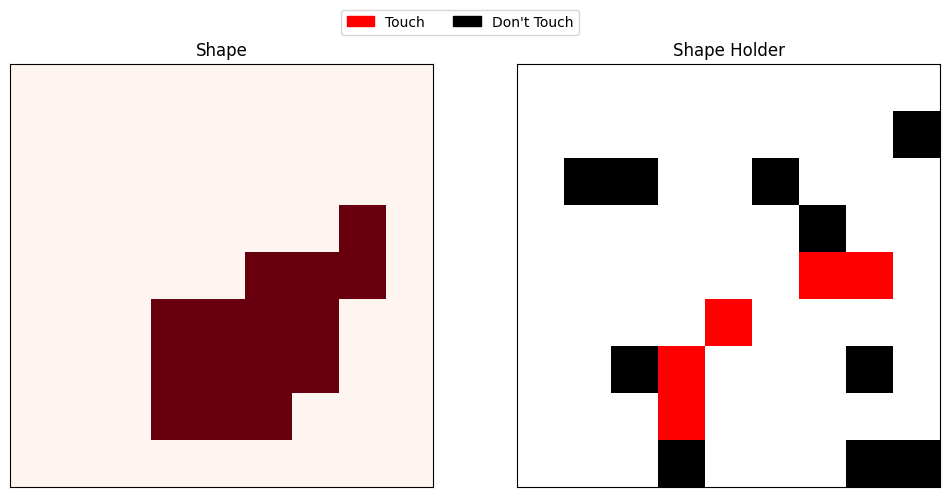

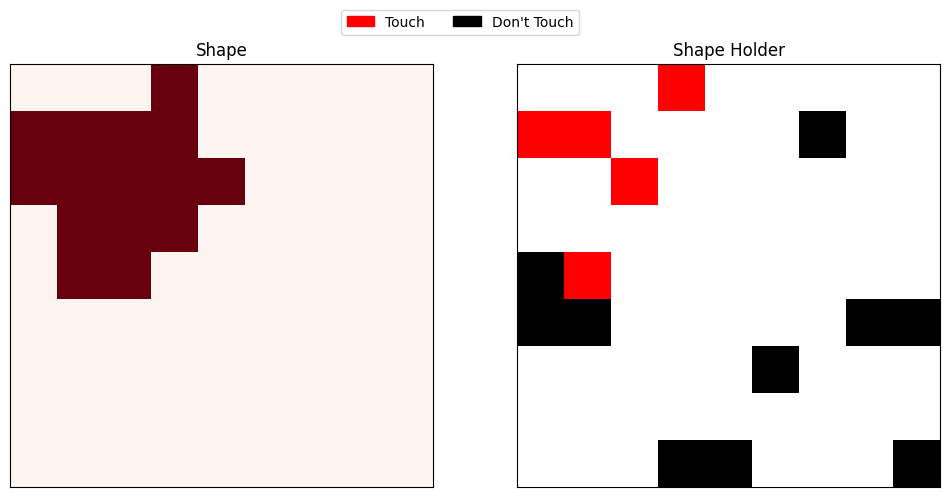

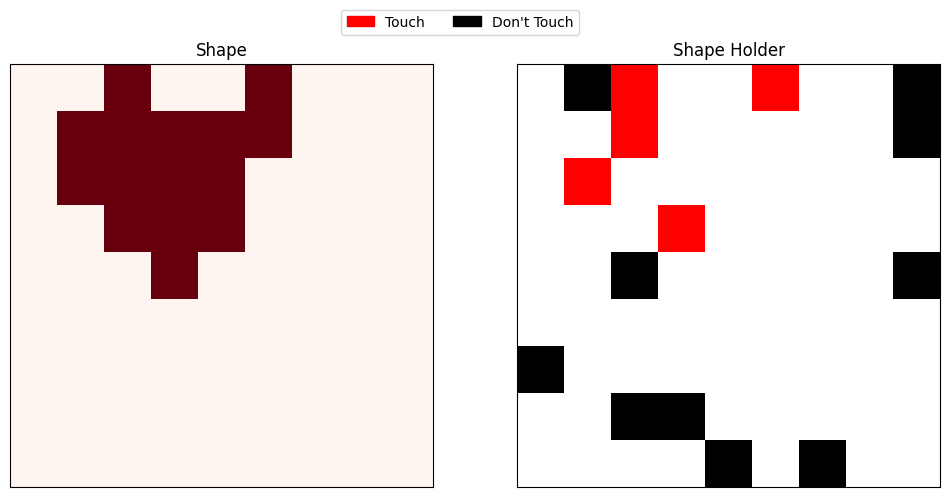

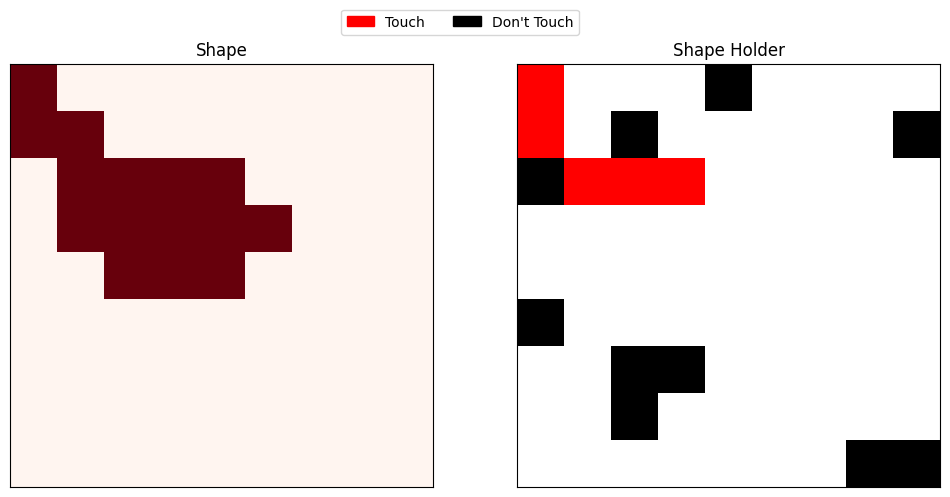

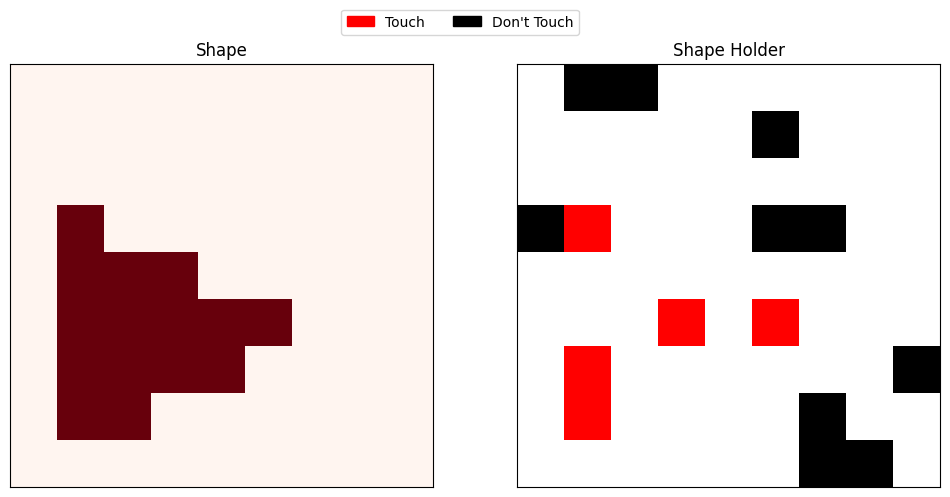

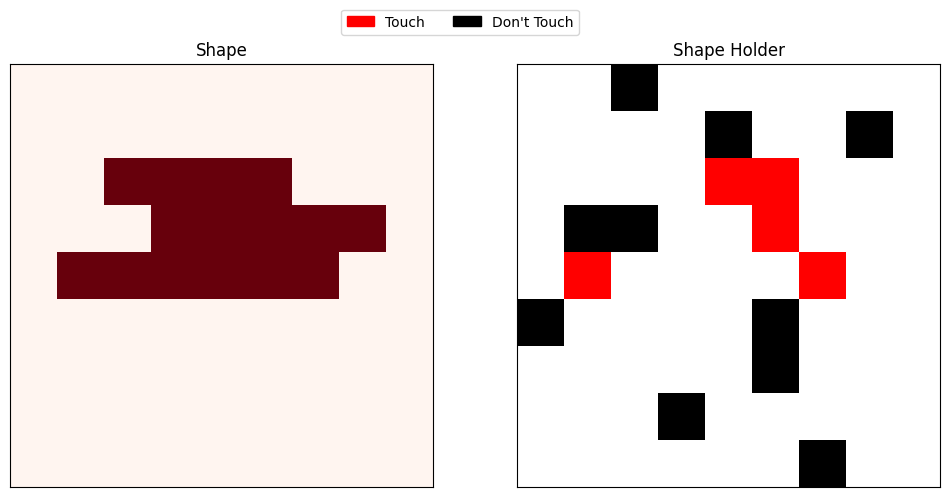

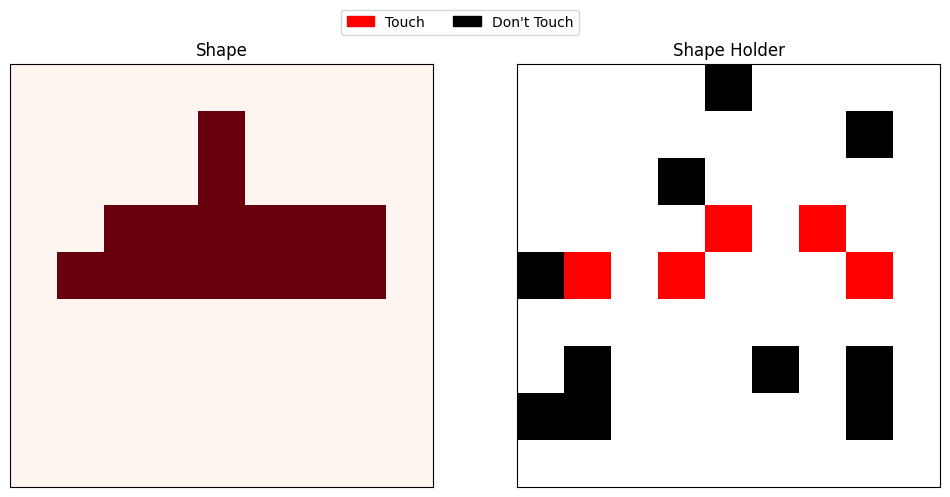

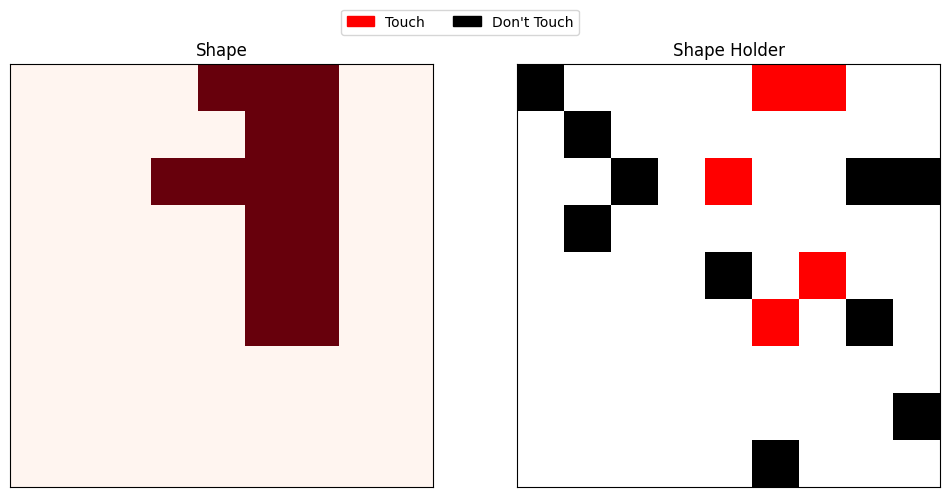

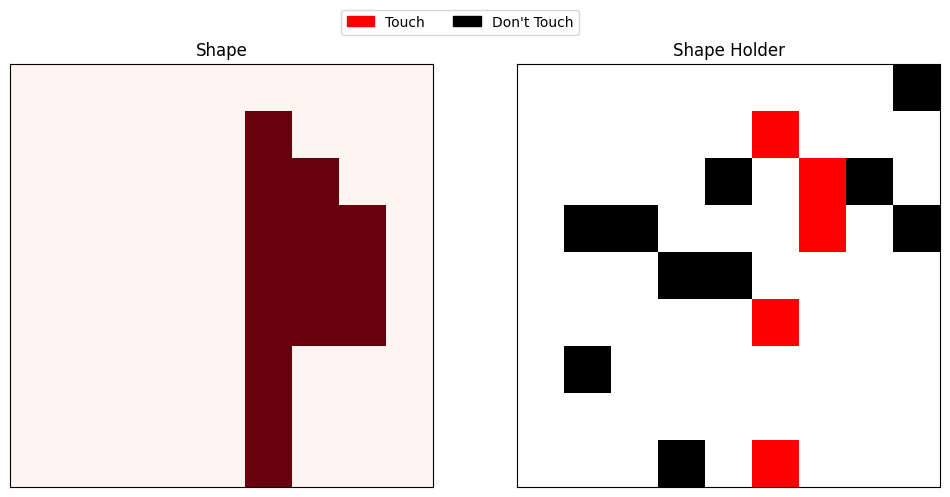

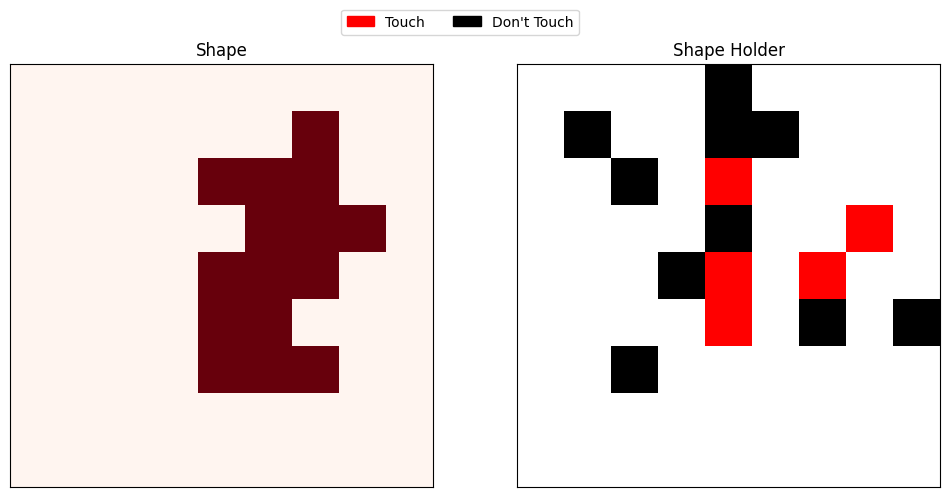

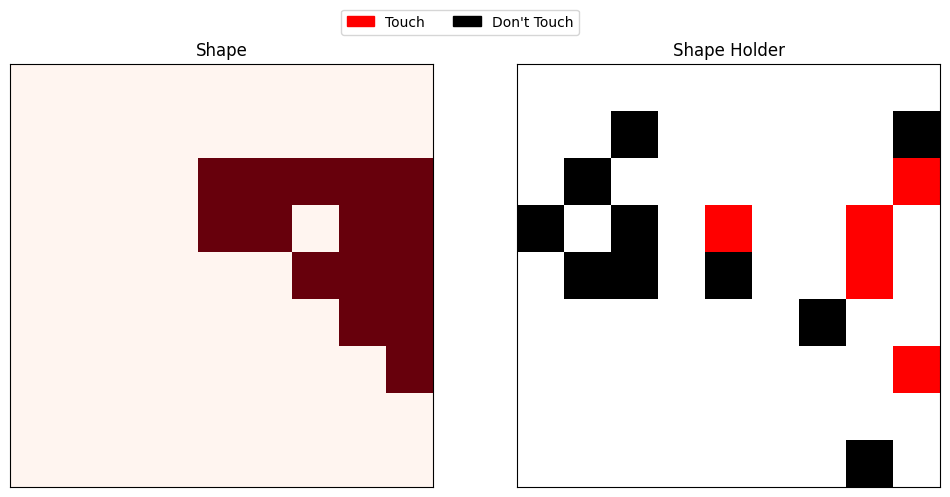

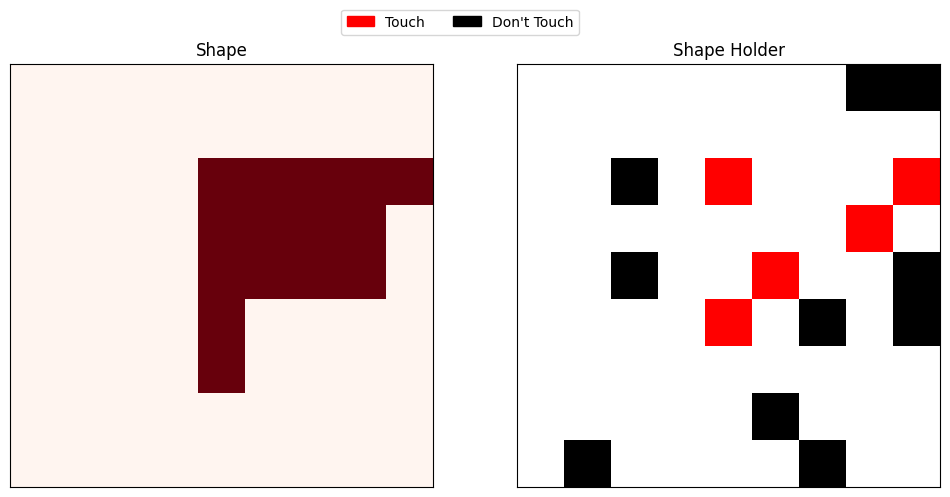

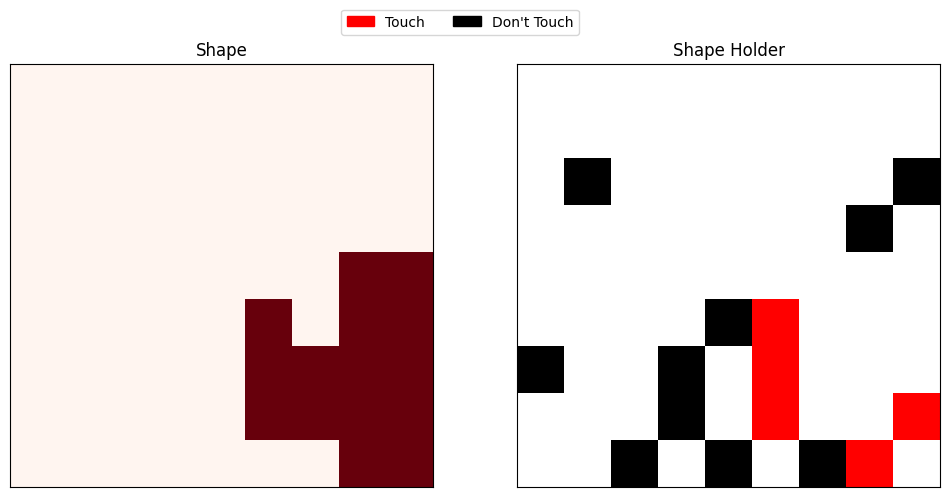

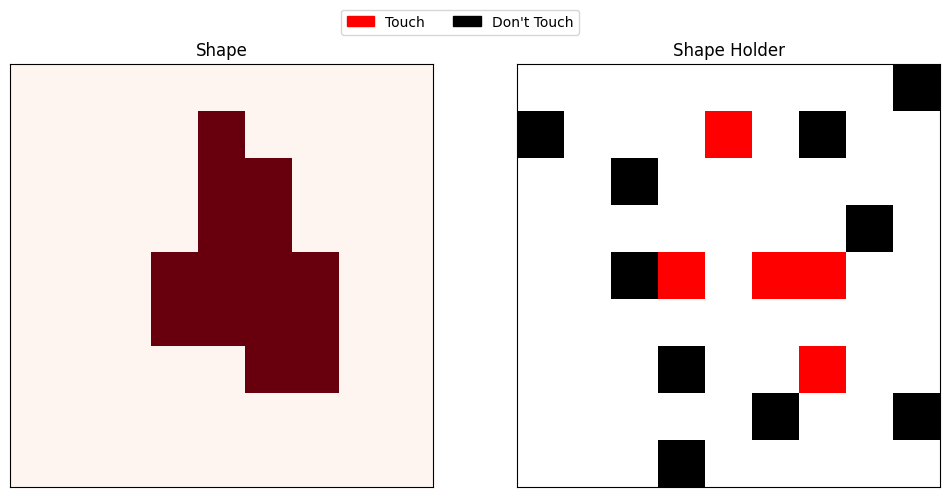

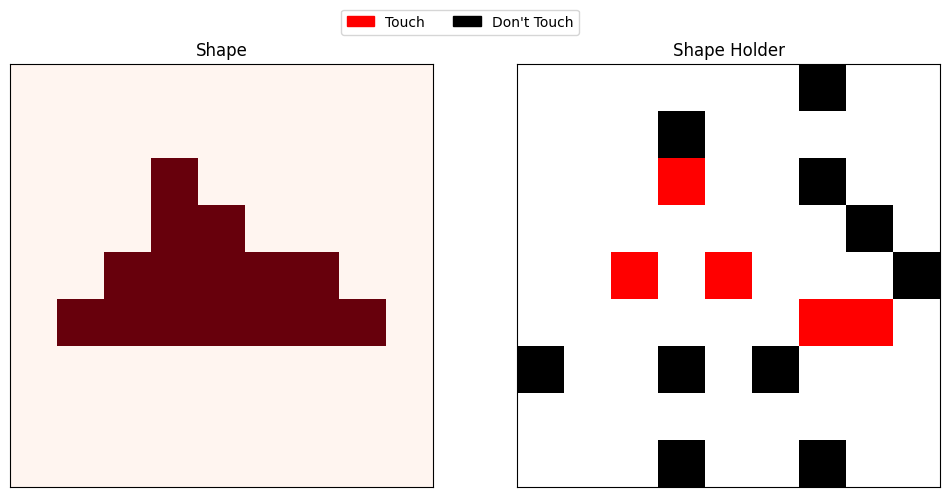

In [43]:
for shapetxt in loaded_shapes_dict:
    shape_holder = loaded_shapes_dict[shapetxt]
    shape = string_to_array(shapetxt)
    shape = getAlignment(shape,shape_holder)
    display_shape_and_holder(shape,shape_holder)